In [2]:
import copy
import os
import sys
from datetime import datetime
from typing import List, Union
import matplotlib.pyplot as plt
plt.style.use('bmh')
from scipy import signal
import seaborn as sns
from pathlib import Path
import warnings
import pickle
# !pip install pytorch_forecasting
# !pip install pytorch_lightning
# !pip install utils
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

import pytorch_forecasting 
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, encoders
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MultiLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import utils

In [3]:
stocks1 = pd.read_table(
    "Tasas_de_interes_de_captacion_y_operaciones_del_mercado_monetario.csv",
    dtype={
        "TIPOENTIDAD": np.int64,
        "CODIGOENTIDAD": np.int64,
        "NOMBREENTIDAD": str,
        "TASA": np.float64,
        "MONTO": np.float64
    },
    parse_dates=["FECHACORTE"],
    delimiter=";",
    header=0,
    decimal=".",
    thousands=",",
    dayfirst=True
);

df = pd.DataFrame()

stocks1['FECHACORTE'] = pd.to_datetime(stocks1['FECHACORTE'], format='%m/%d/%Y')

df = stocks1.groupby('NOMBREENTIDAD').filter(lambda x: len(x) >= 1317)

df['NOMBREENTIDAD'].unique()

array(['BANCO DE BOGOTA ', 'BANCO POPULAR ', 'ITAU CORPBANCA COLOMBIA ',
       'BANCOLOMBIA ', 'BANCO GNB SUDAMERIS ', 'BANCO BBVA',
       'BANCO DE OCCIDENTE ', 'BANCO CAJA SOCIAL ', 'BANCO DAVIVIENDA ',
       'SCOTIABANK COLPATRIA ', 'BANCO AGRARIO DE COLOMBIA ',
       'BANCO DE LAS MICROFINANZAS BANCAMIA ', 'BANCO W ',
       'BANCO COOMEVA ', 'BANCO FINANDINA ', 'BANCO FALABELLA ',
       'BANCO PICHINCHA ', 'BANCO MUNDO MUJER ', 'MIBANCO ',
       'COLTEFINANCIERA  ', 'OI COLOMBIA ', 'FINANCIERA JURISCOOP',
       'COOPERATIVA FINANCIERA DE ANTIOQUIA',
       'JFK COOPERATIVA FINANCIERA', 'COOFINEP COOPERATIVA FINANCIERA',
       'COTRAFA FINANCIERA', 'CONFIAR COOPERATIVA FINANCIERA'],
      dtype=object)

In [4]:
df

TIPOENTIDAD  CODIGOENTIDAD                   NOMBREENTIDAD FECHACORTE  \
0                1              1                BANCO DE BOGOTA  2018-01-02   
1                1              1                BANCO DE BOGOTA  2018-01-03   
2                1              1                BANCO DE BOGOTA  2018-01-04   
3                1              1                BANCO DE BOGOTA  2018-01-05   
4                1              1                BANCO DE BOGOTA  2018-01-09   
...            ...            ...                             ...        ...   
47009           32              5  CONFIAR COOPERATIVA FINANCIERA 2023-05-17   
47010           32              5  CONFIAR COOPERATIVA FINANCIERA 2023-05-18   
47011           32              5  CONFIAR COOPERATIVA FINANCIERA 2023-05-19   
47012           32              5  CONFIAR COOPERATIVA FINANCIERA 2023-05-23   
47013           32              5  CONFIAR COOPERATIVA FINANCIERA 2023-05-24   

       TASA        MONTO  
0      4.77  15784270.00  
1      4.82  14664331.00  
2      4.58   9616842.00  
3      4.66  14426755.00  
4      4.77  11691688.00  
...     ...          ...  
47009  7.35   3167247.92  
47010  7.38   3739878.74  
47011  7.02   6256846.37  
47012  8.54  12458597.07  
47013  7.59   3395274.18  

[35643 rows x 6 columns]

In [6]:
df['FECHACORTE'] = pd.to_datetime(df['FECHACORTE'])
df['MES'] = df['FECHACORTE'].apply(lambda x: str(x.month))
df['time_idx'] = df['FECHACORTE'].apply(lambda x: int(x.year*365 + x.month*30 + x.day))
df['time_idx'] = df['time_idx'] - min(df['time_idx'])

df['TIPOENTIDAD'] = df['TIPOENTIDAD'].astype(str)
df['DIASEMANA'] = df['FECHACORTE'].dt.weekday.astype(str)

max_prediction_length = 100
max_encoder_length = 2*100
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="TASA",
    group_ids=['NOMBREENTIDAD'],    #['TIPOENTIDAD', 'NOMBREENTIDAD', 'MES', 'DIASEMANA'],
    static_categoricals=['TIPOENTIDAD', 'NOMBREENTIDAD'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=['MONTO', 'MES','DIASEMANA',],
    time_varying_unknown_reals=['TASA'],
    target_normalizer=GroupNormalizer(
        groups=['NOMBREENTIDAD'], transformation="softplus"
    ),
    lags={'TASA': [60]},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    categorical_encoders={
        'S100': pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'I100':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'C100':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'C101':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True)
    }
)

validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

batch_size = 60
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 5, num_workers=4)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
print((actuals - baseline_predictions.to('cpu')).abs().mean().item())

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)


C:\Users\LENOVO\anaconda3\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


1.4419184923171997


Missing logger folder: lightning_logs\lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 279   
3  | prescalers                         | ModuleDict                      | 2.9 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 314 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 628 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 418 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K 
9  | static_context_initial

Number of parameters in network: 2639.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

C:\Users\LENOVO\anaconda3\lib\site-packages\lightning\pytorch\trainer\call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

best_model_path

val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)



'''
for idx in range(111):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);
                            '''

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create.

'\nfor idx in range(111):\n    fig, ax = plt.subplots(figsize=(23,5))\n    best_tft.plot_prediction(val_prediction_results.x, # network input\n                            val_prediction_results.output, # network output\n                            idx=idx,\n                            add_loss_to_title=True,\n                            ax=ax);\n                            '

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions.to('cpu')).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions.to('cpu')).abs().mean(axis=1))

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.3270840048789978
tensor([0.1881, 0.3607, 0.0689,  ..., 0.0873, 0.3245, 0.3379])


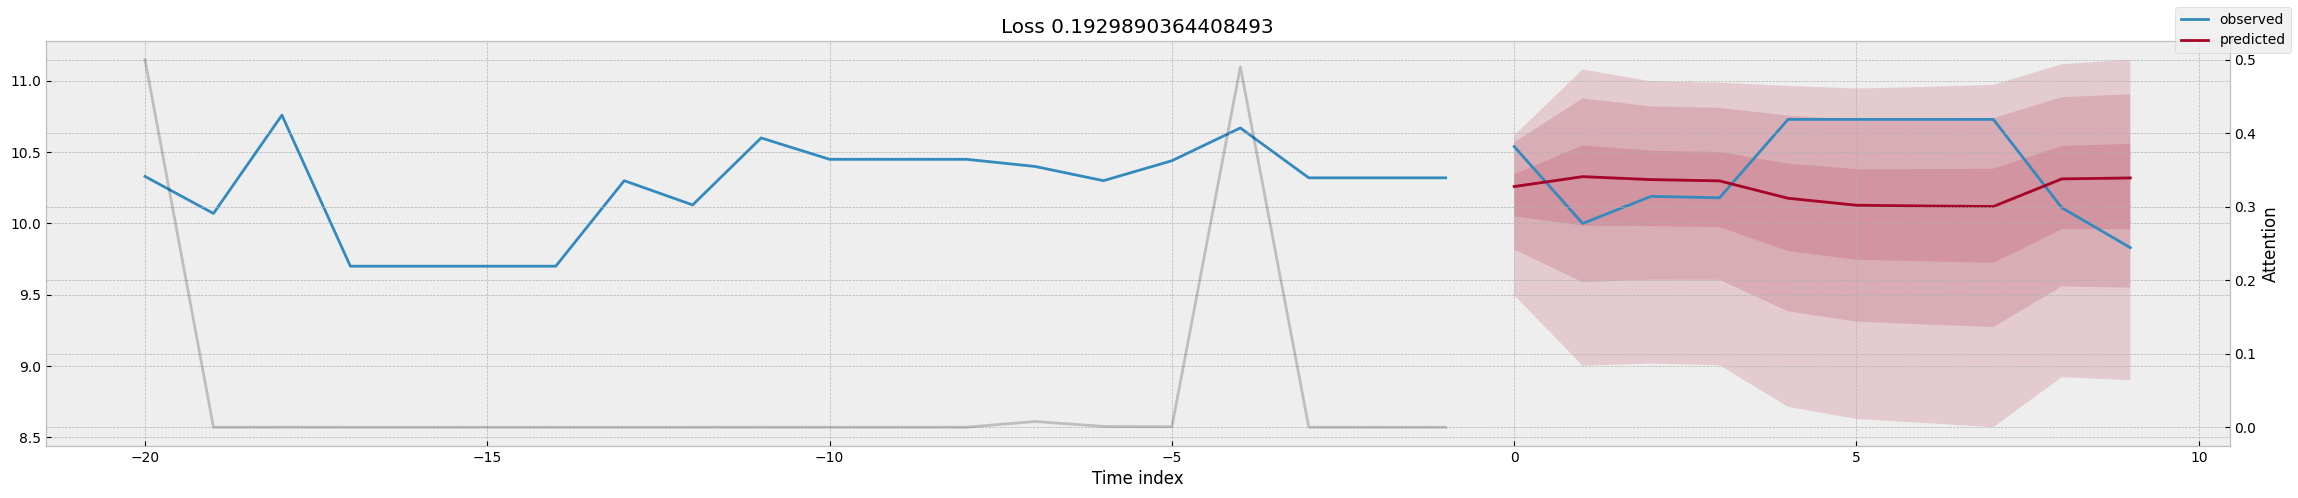

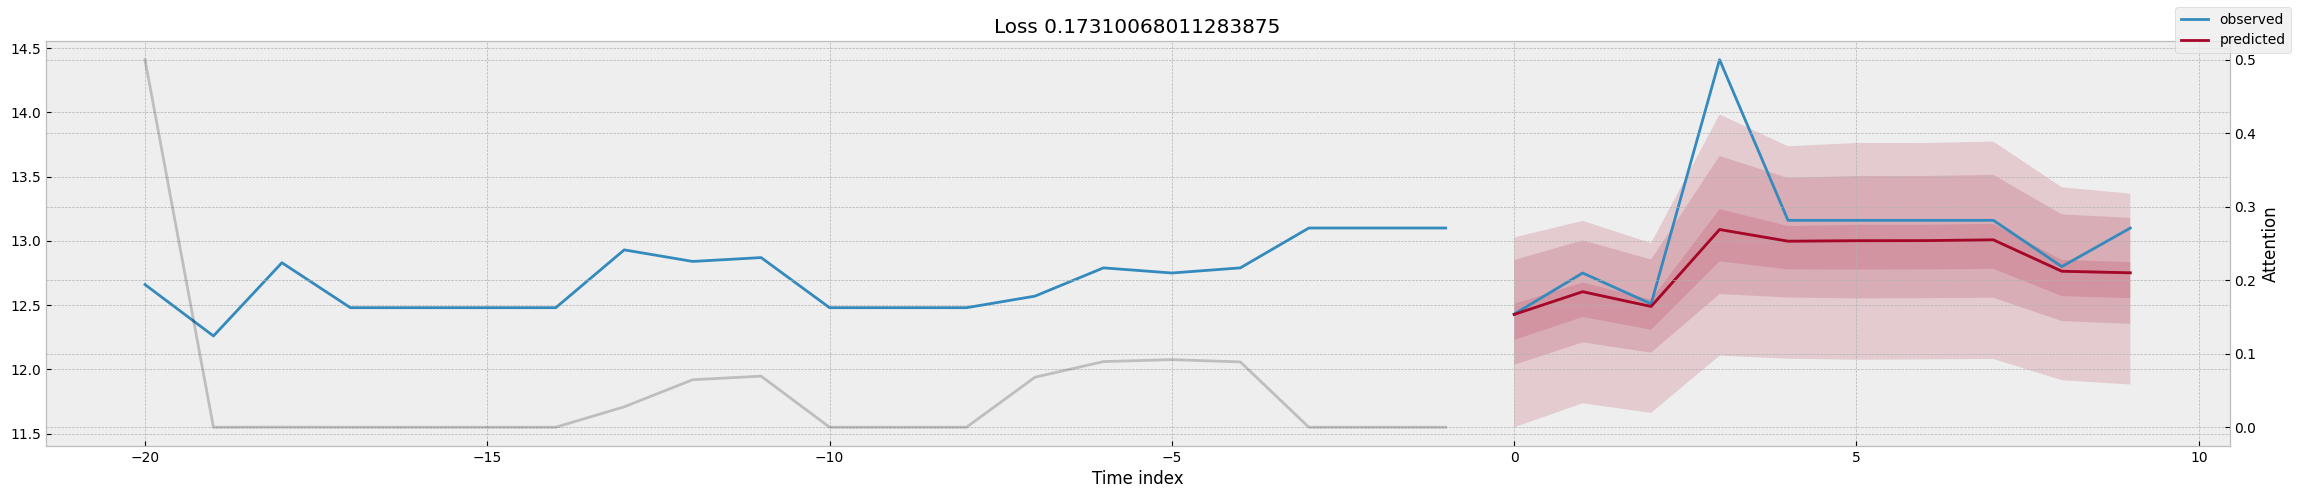

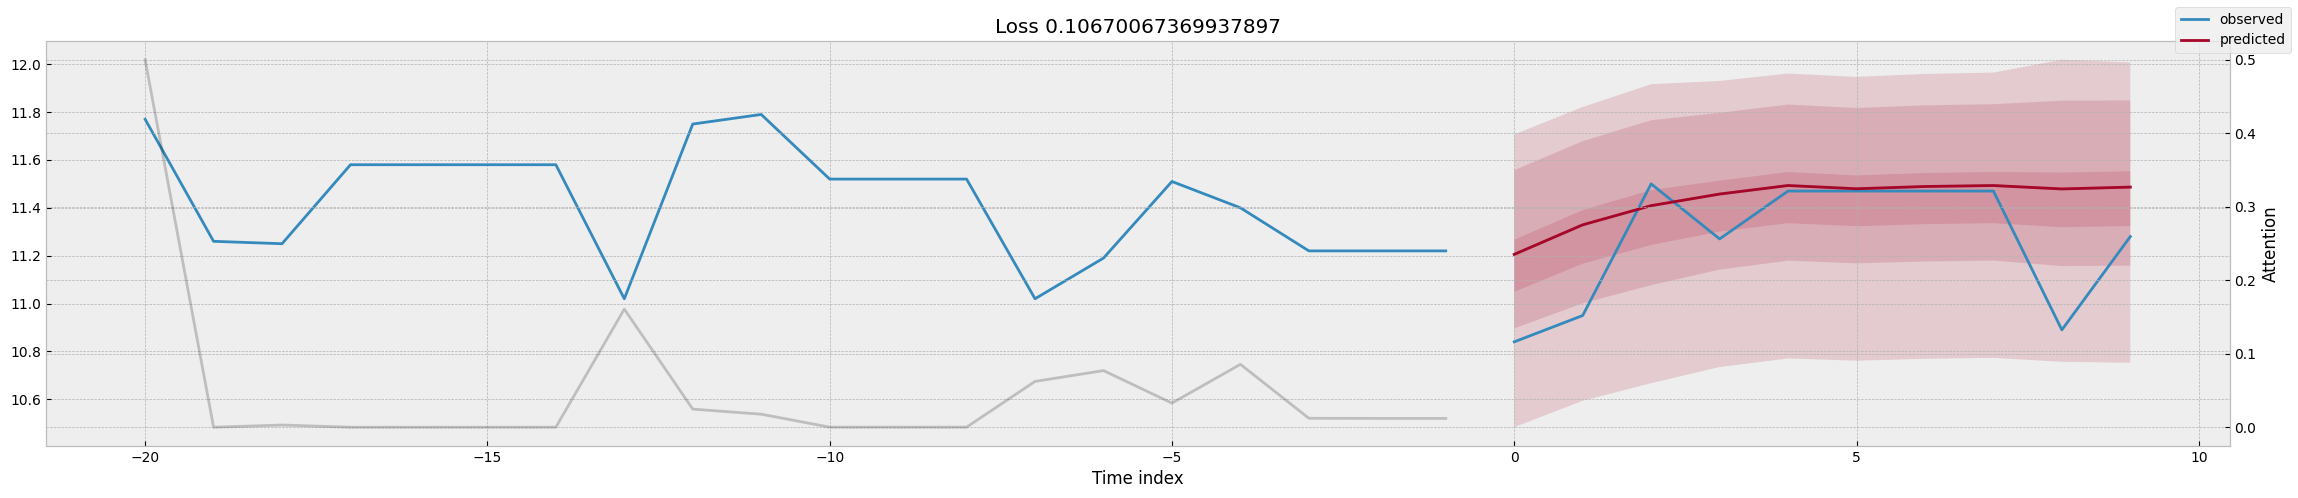

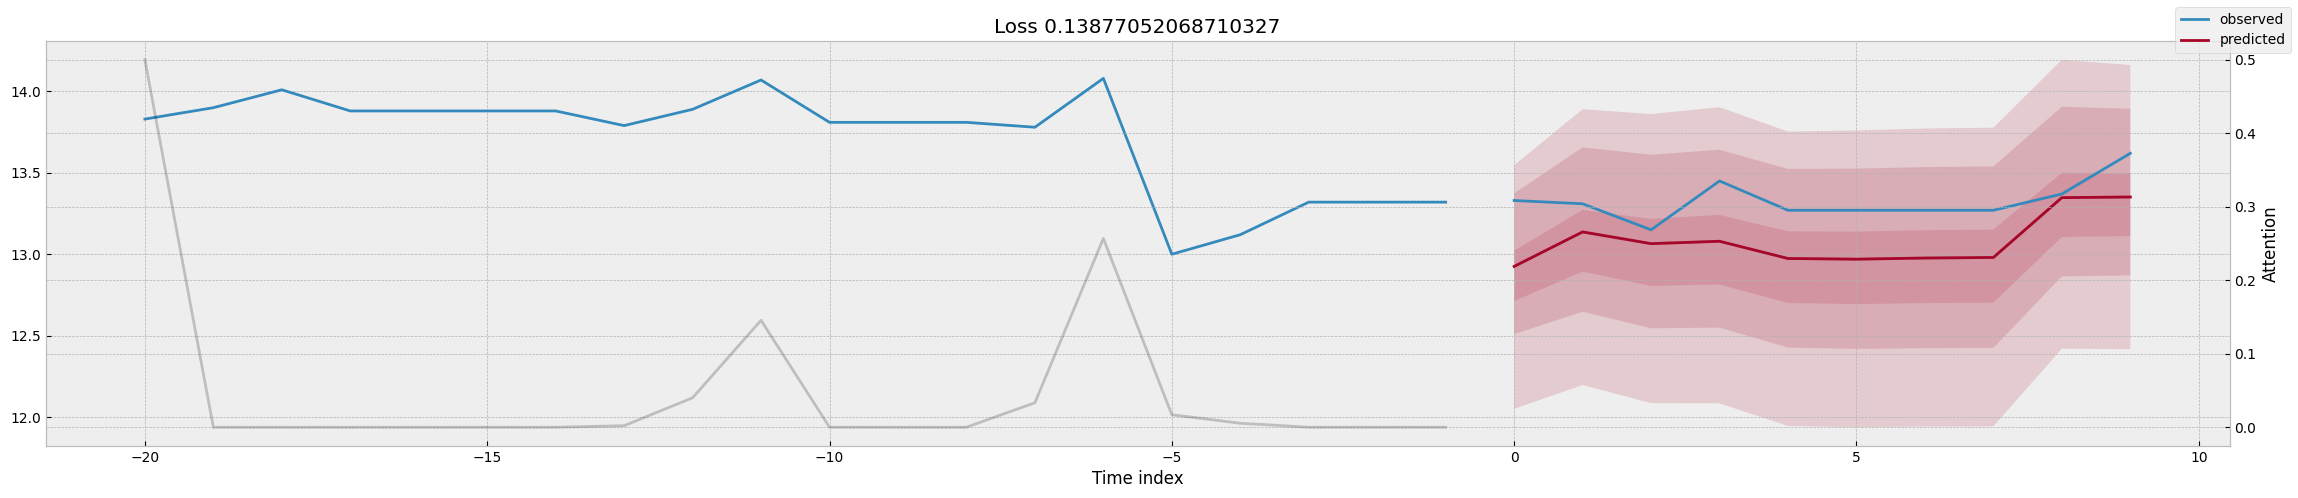

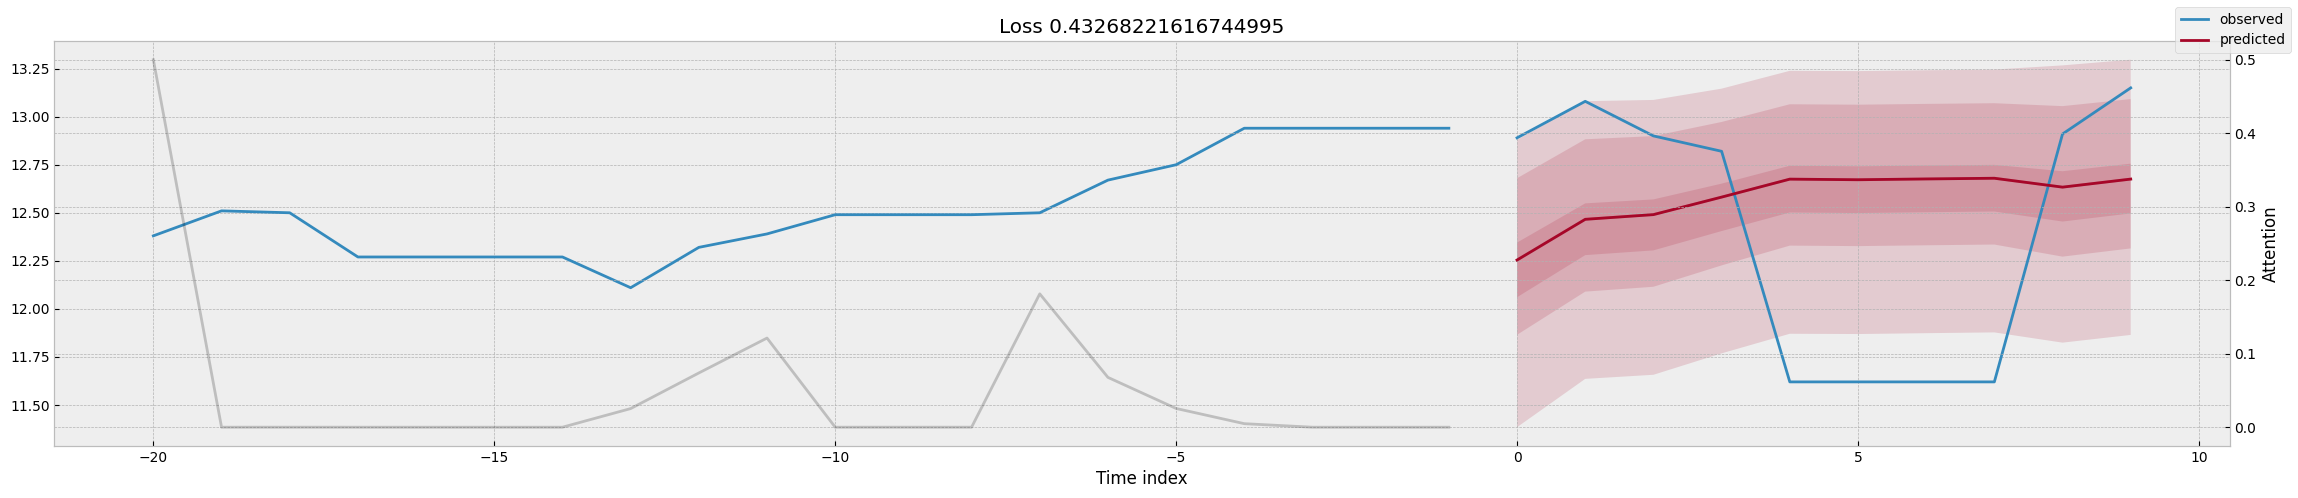

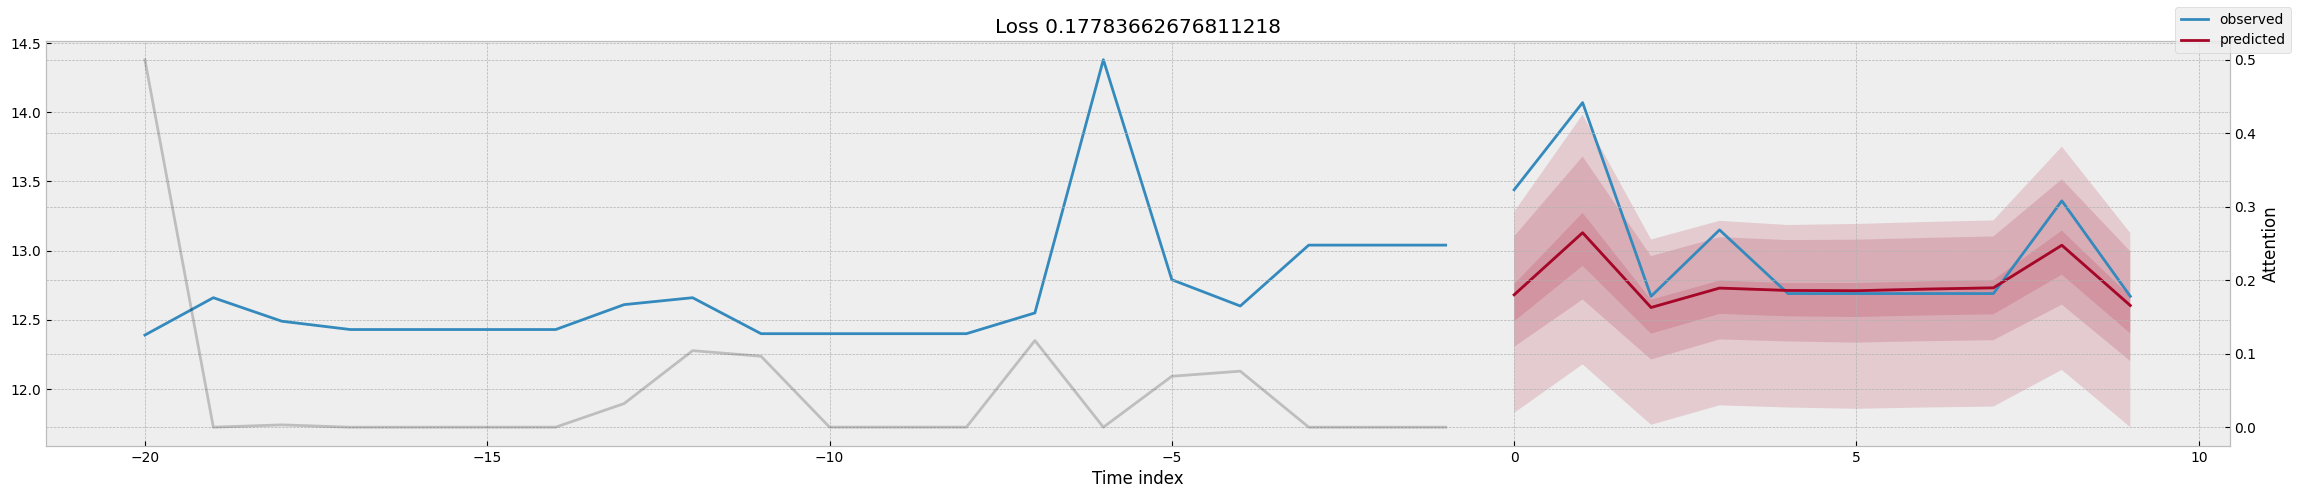

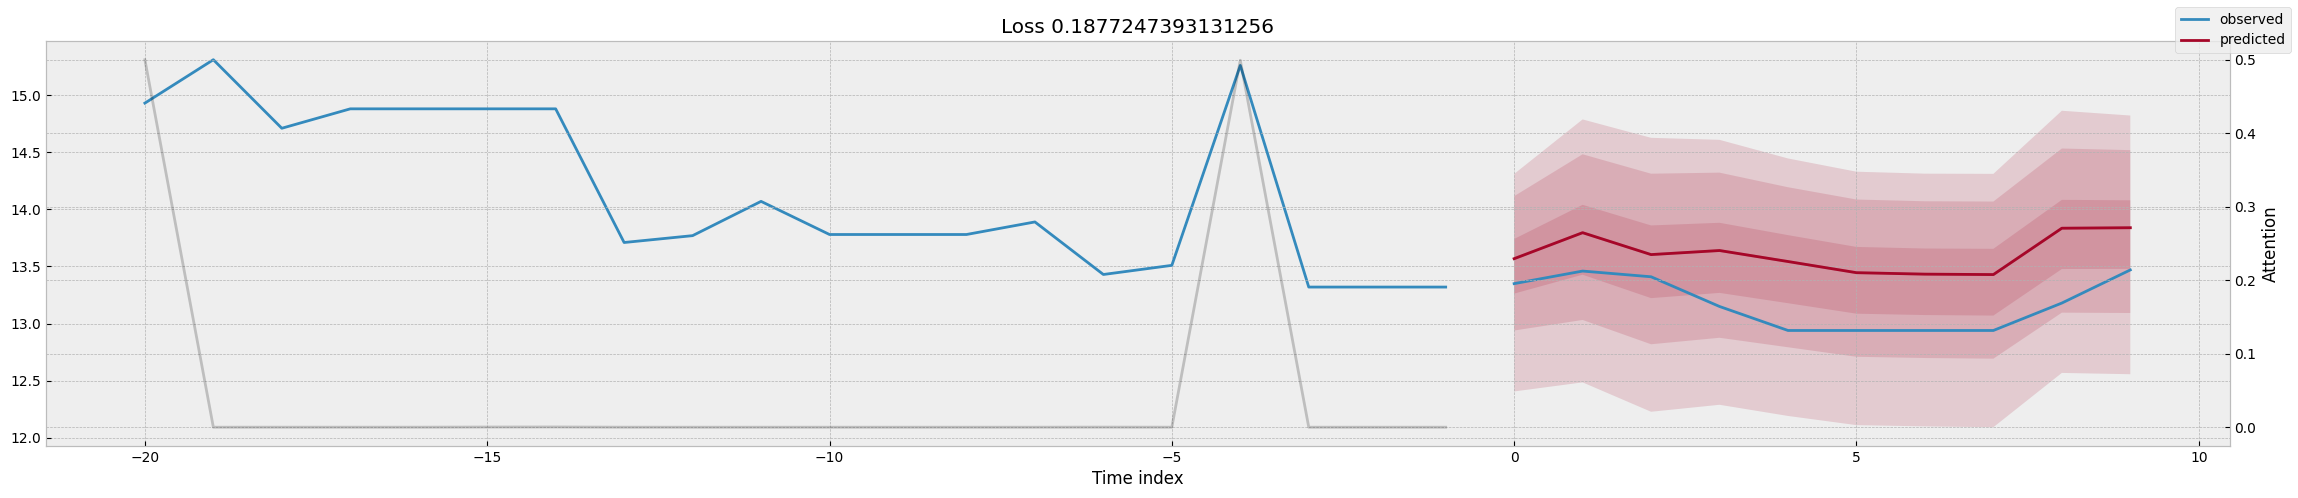

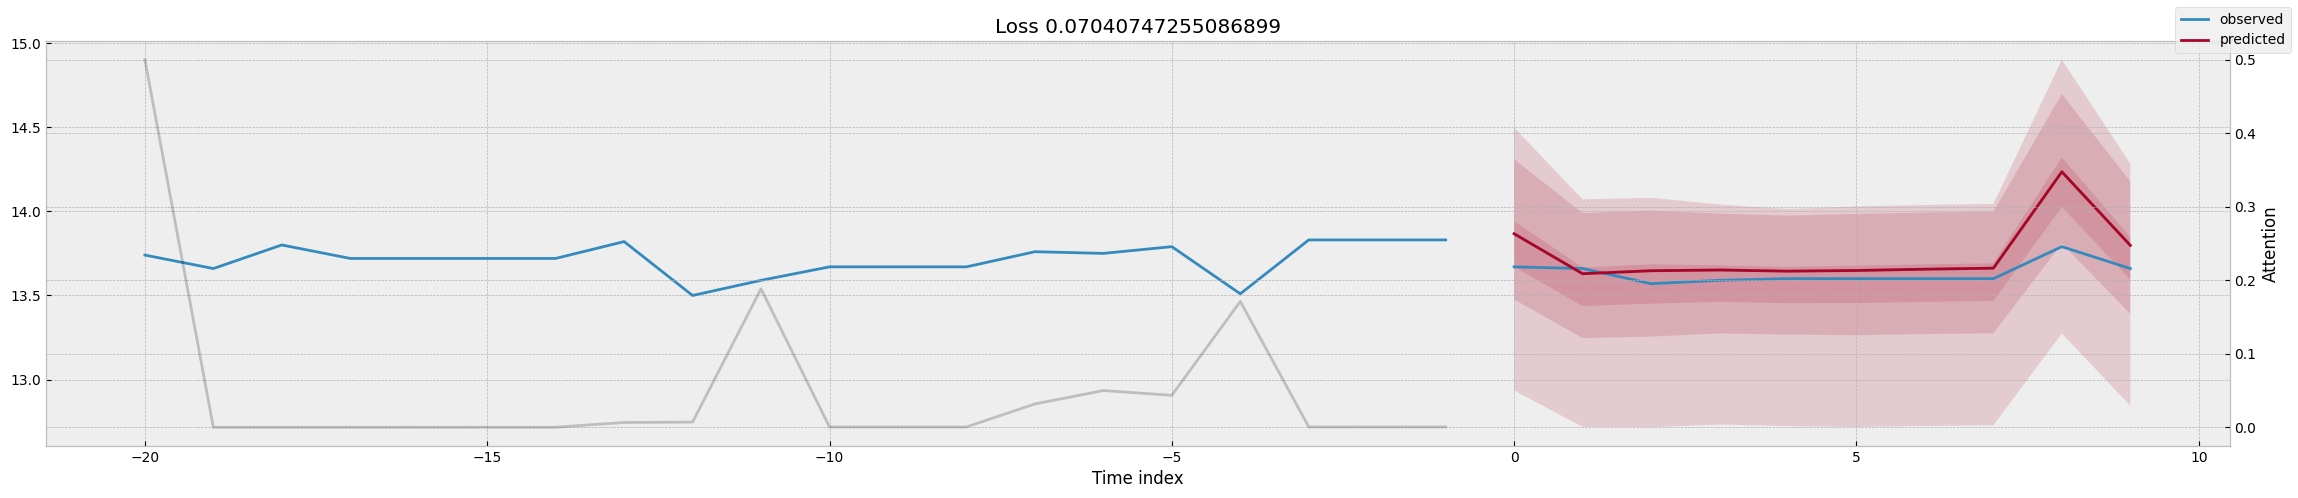

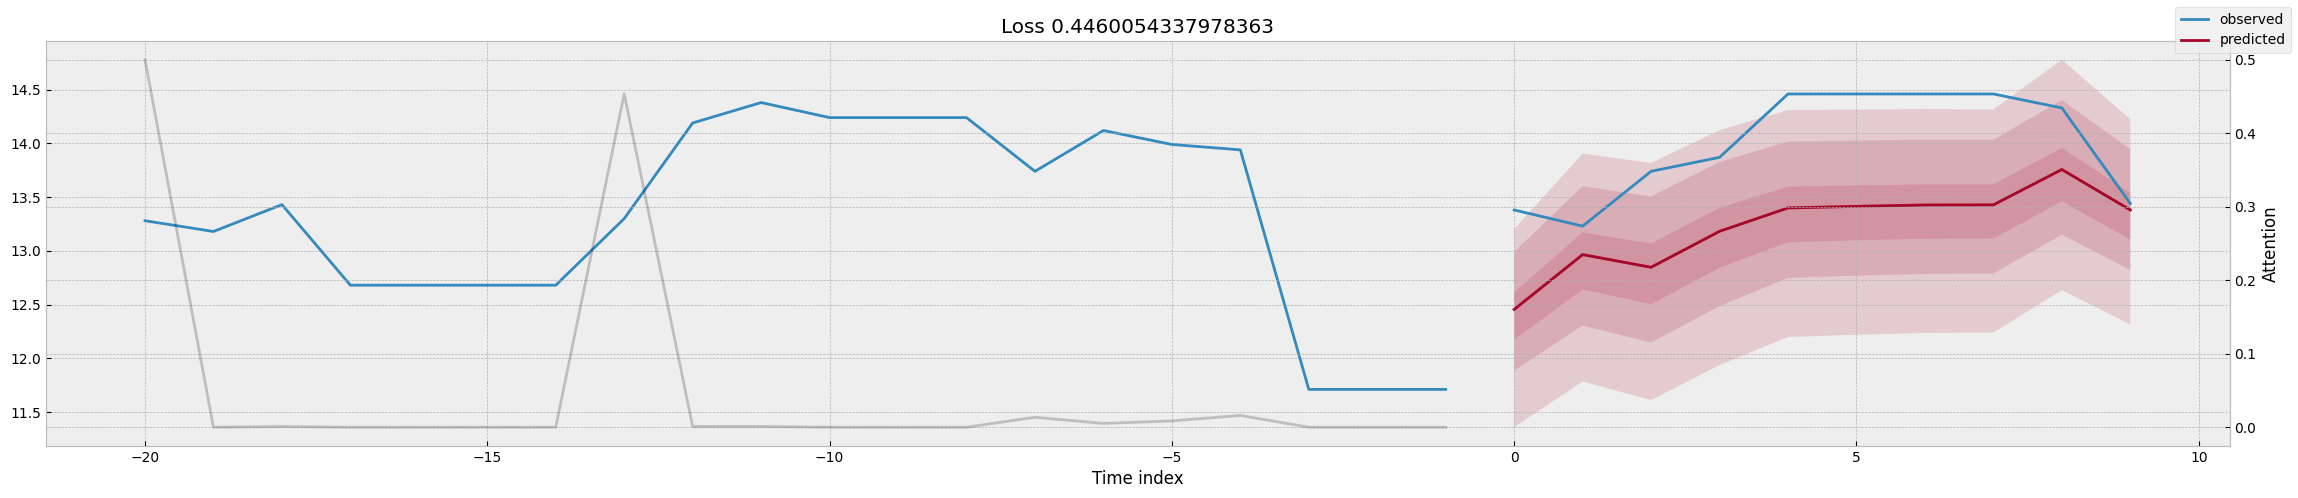

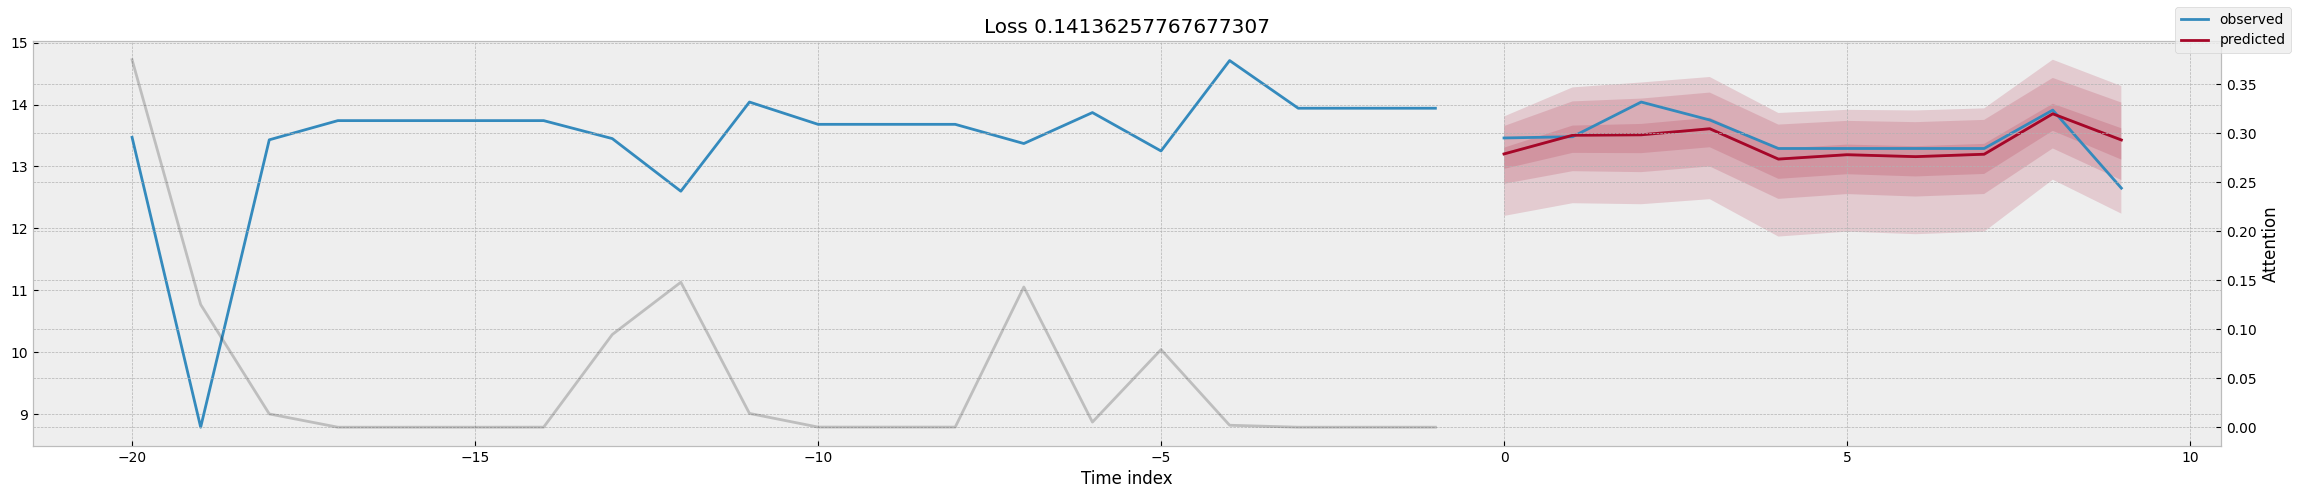

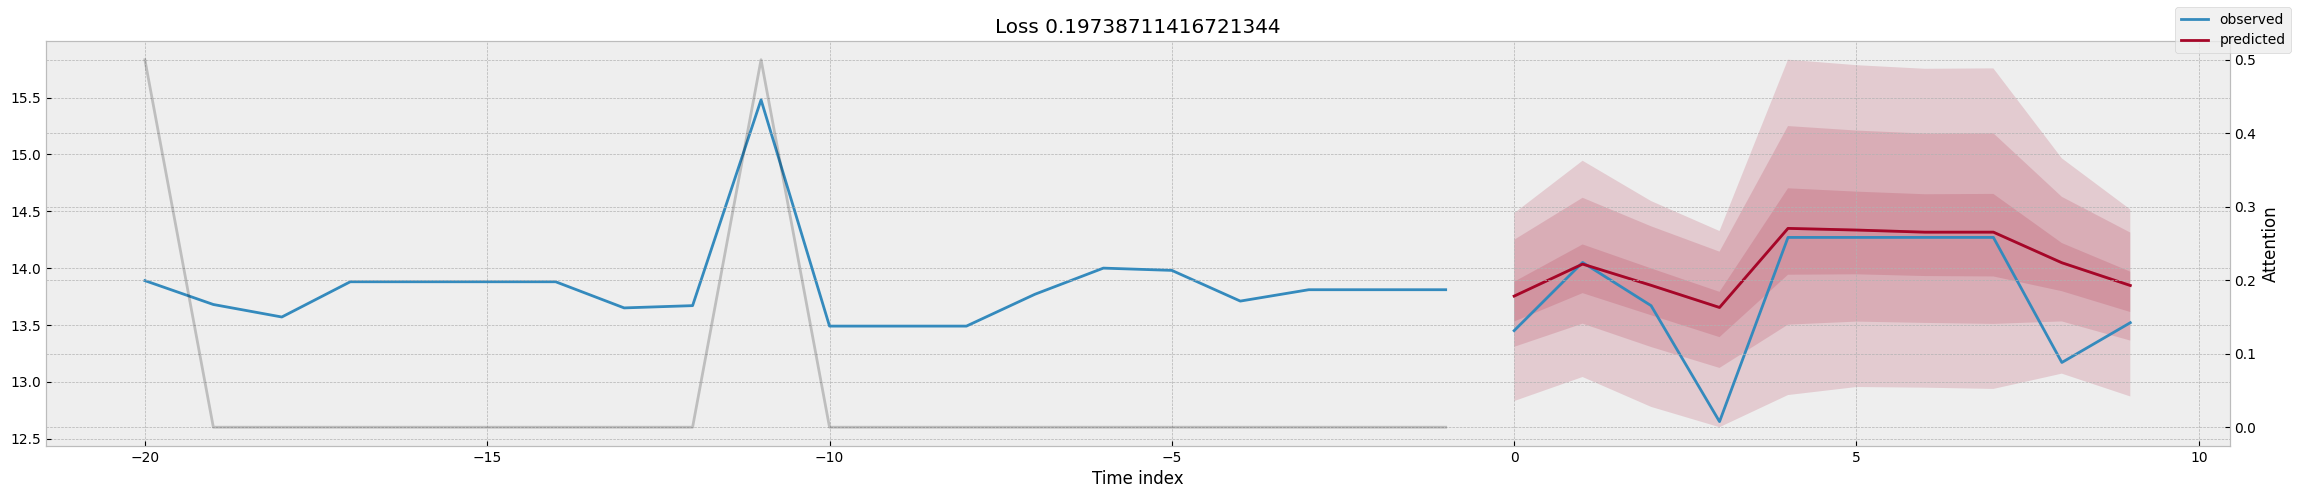

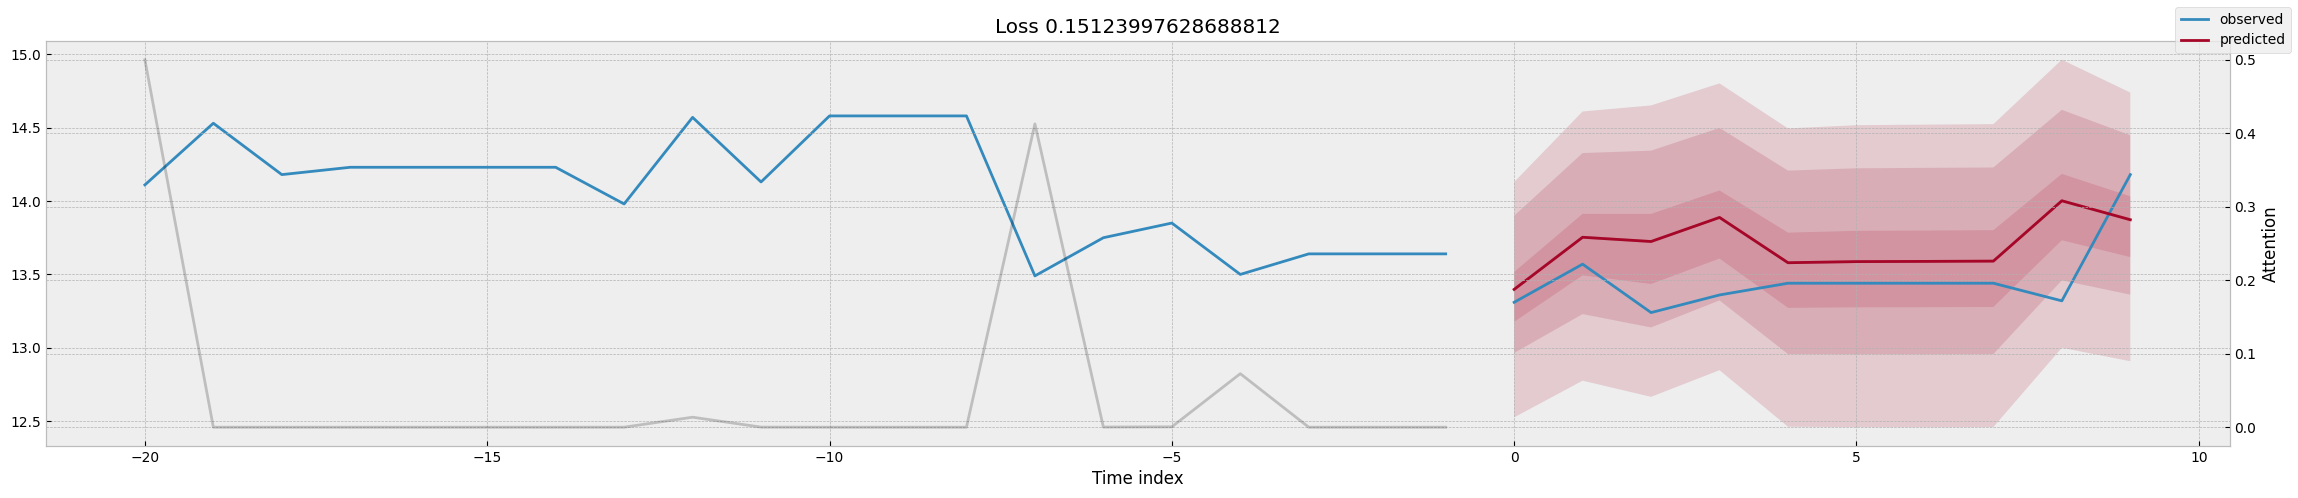

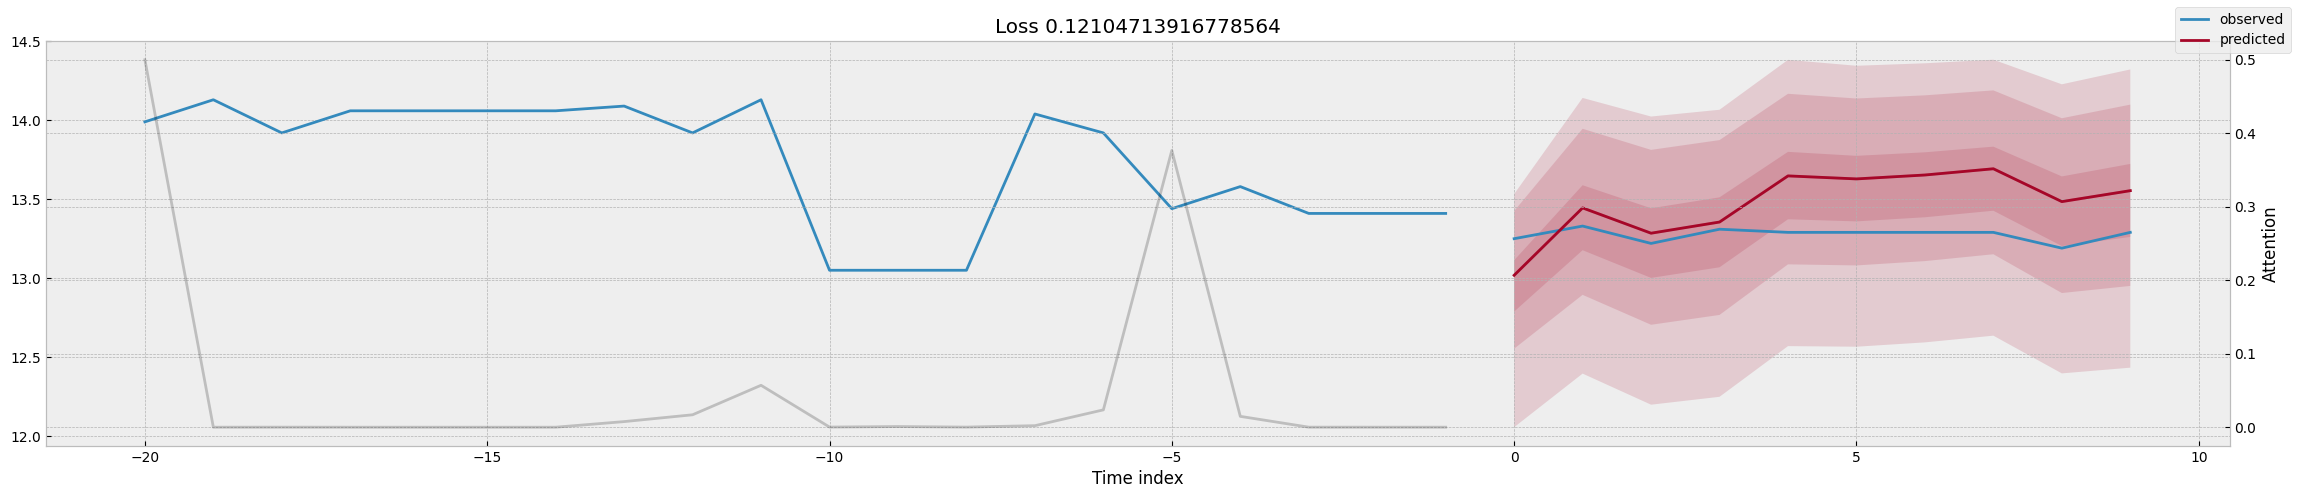

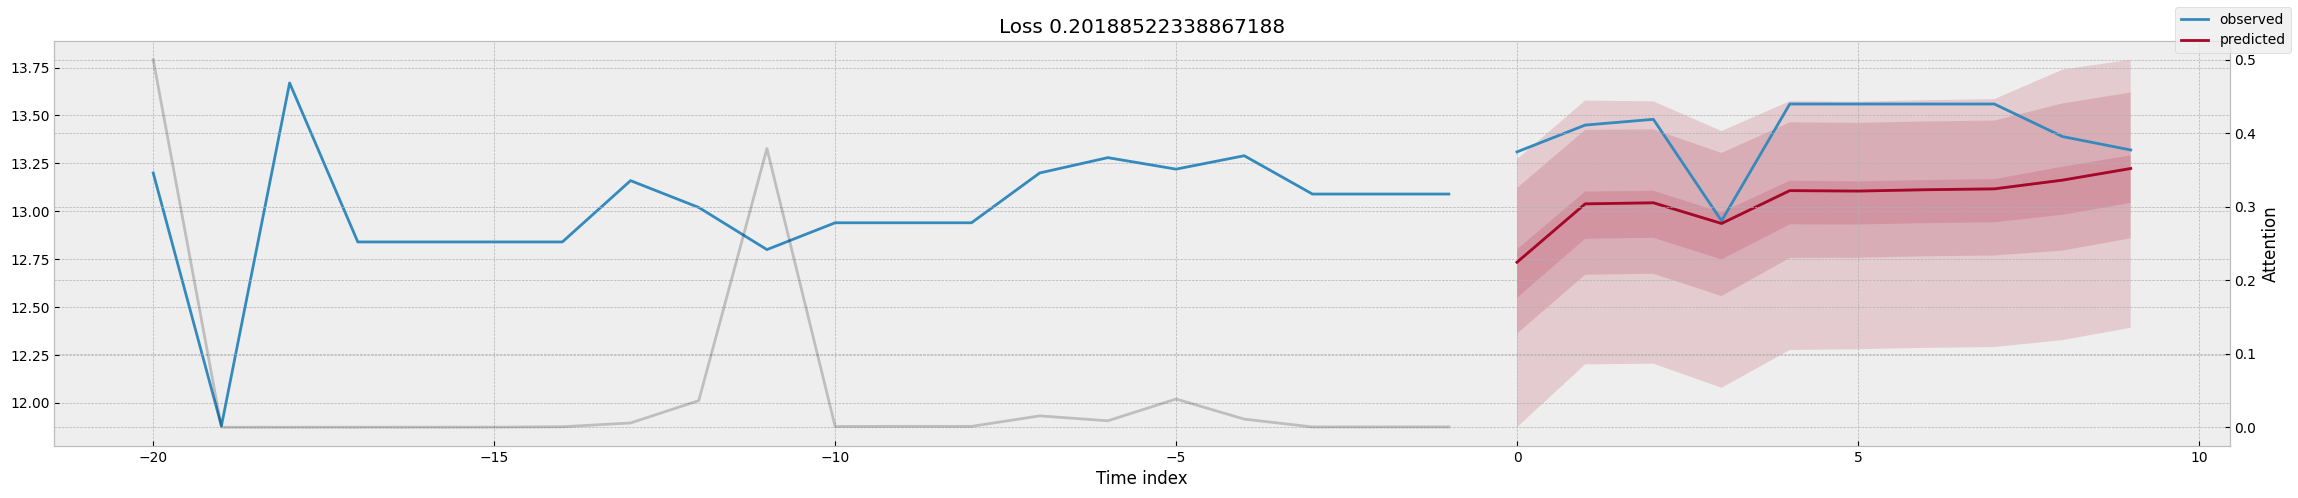

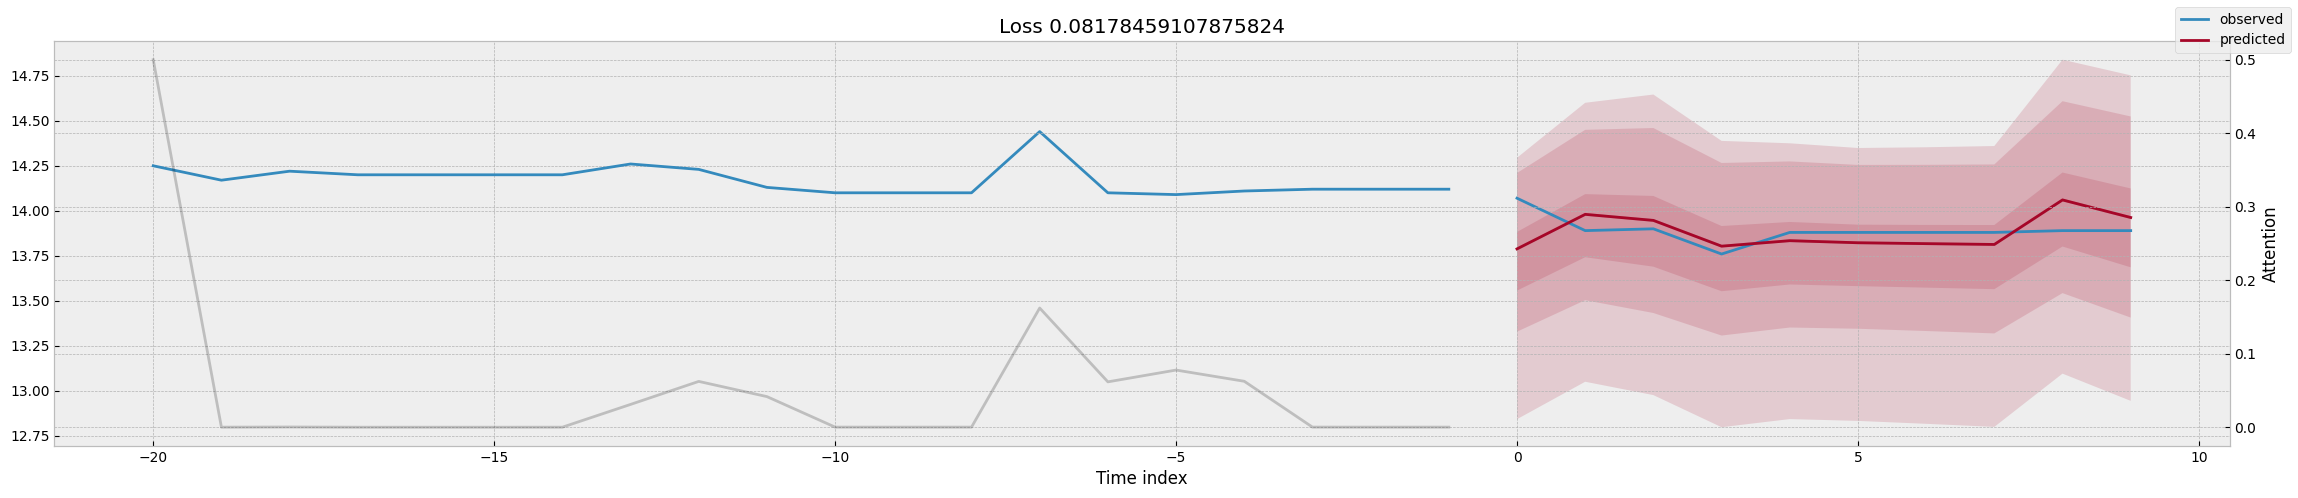

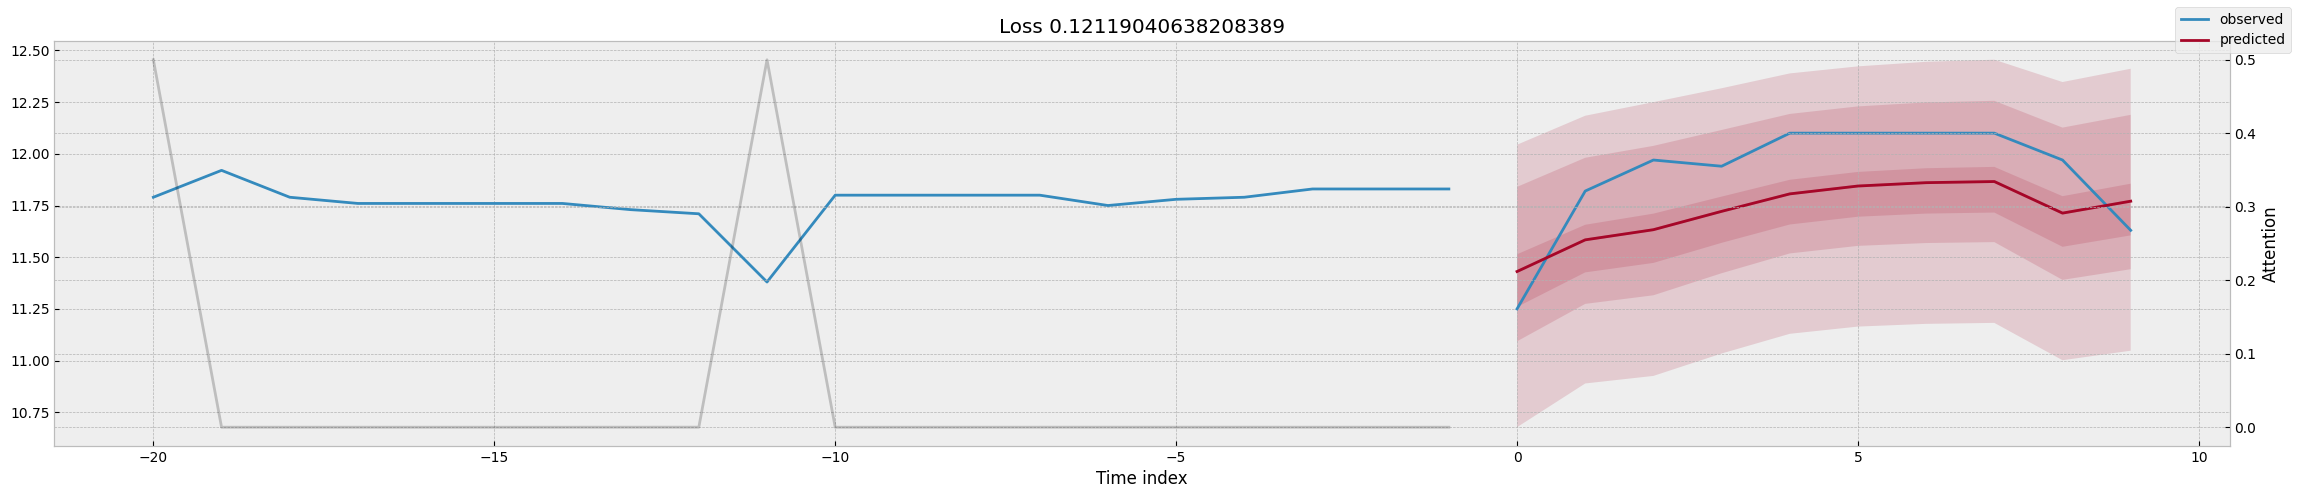

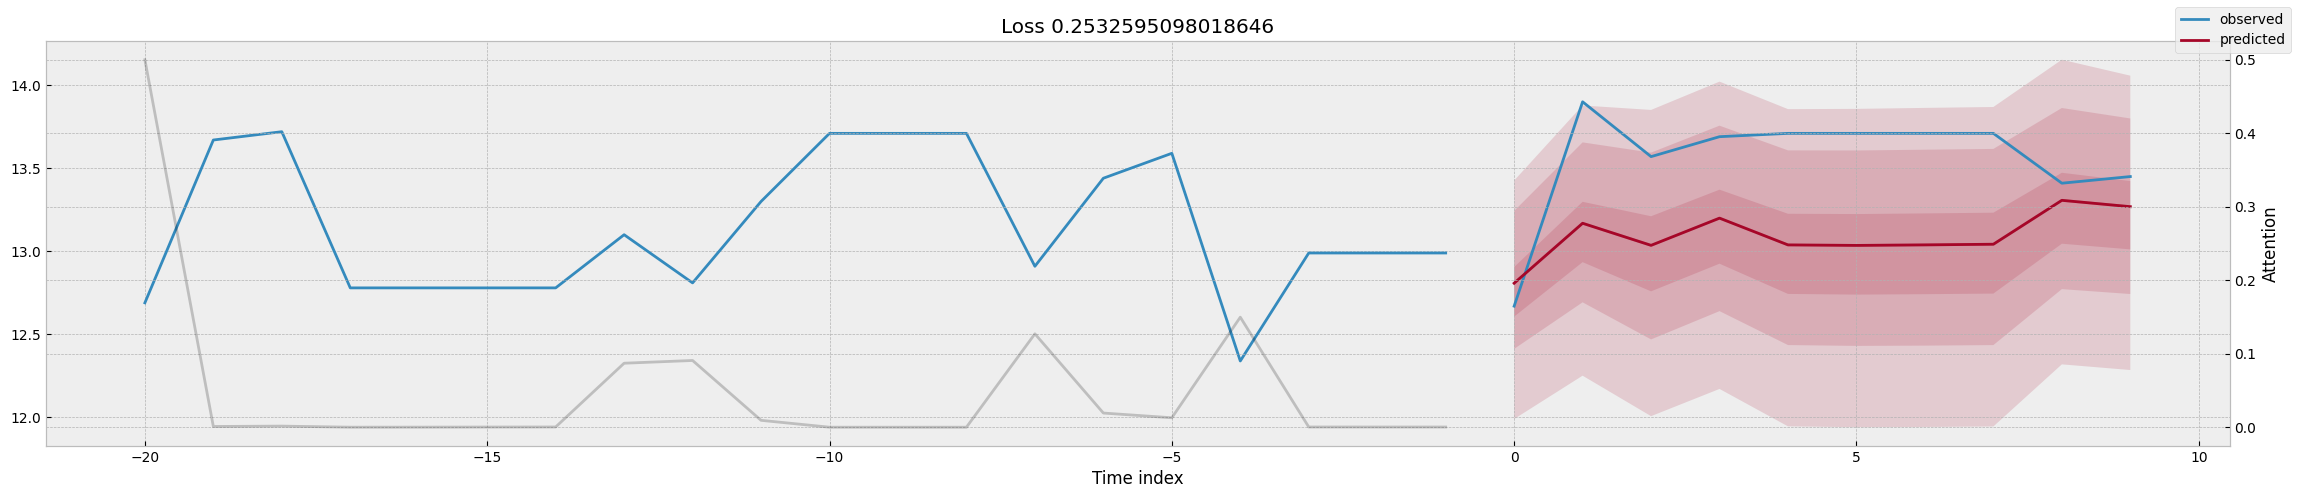

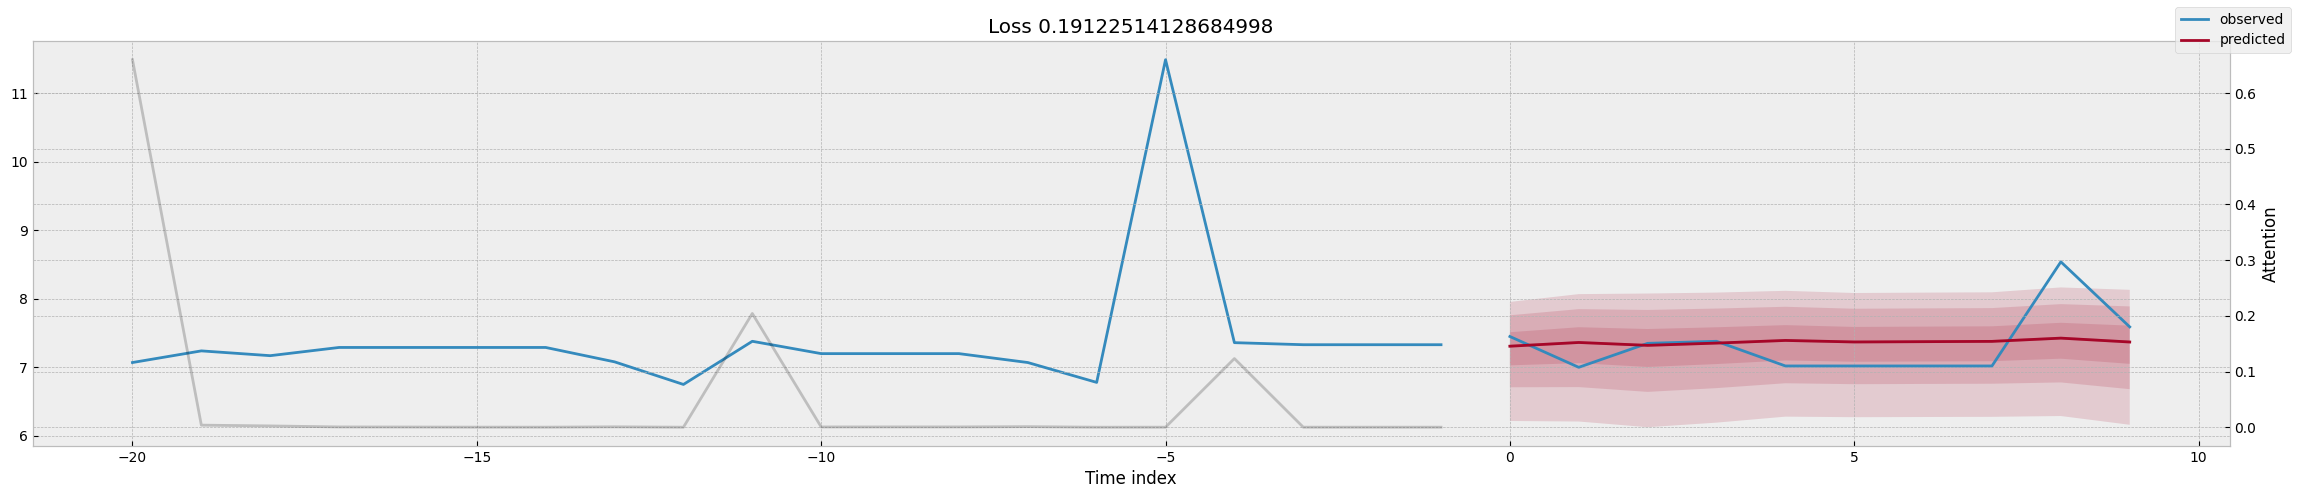

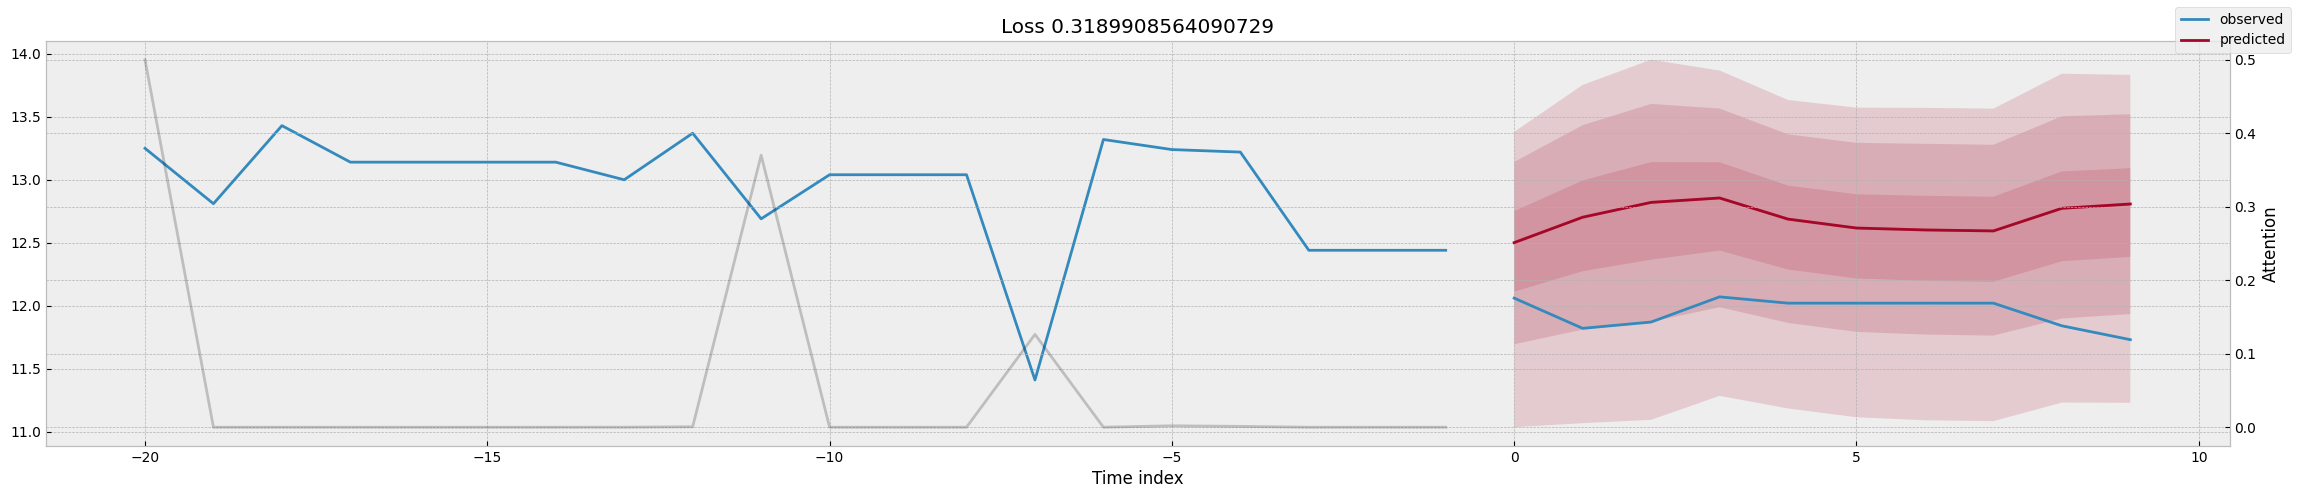

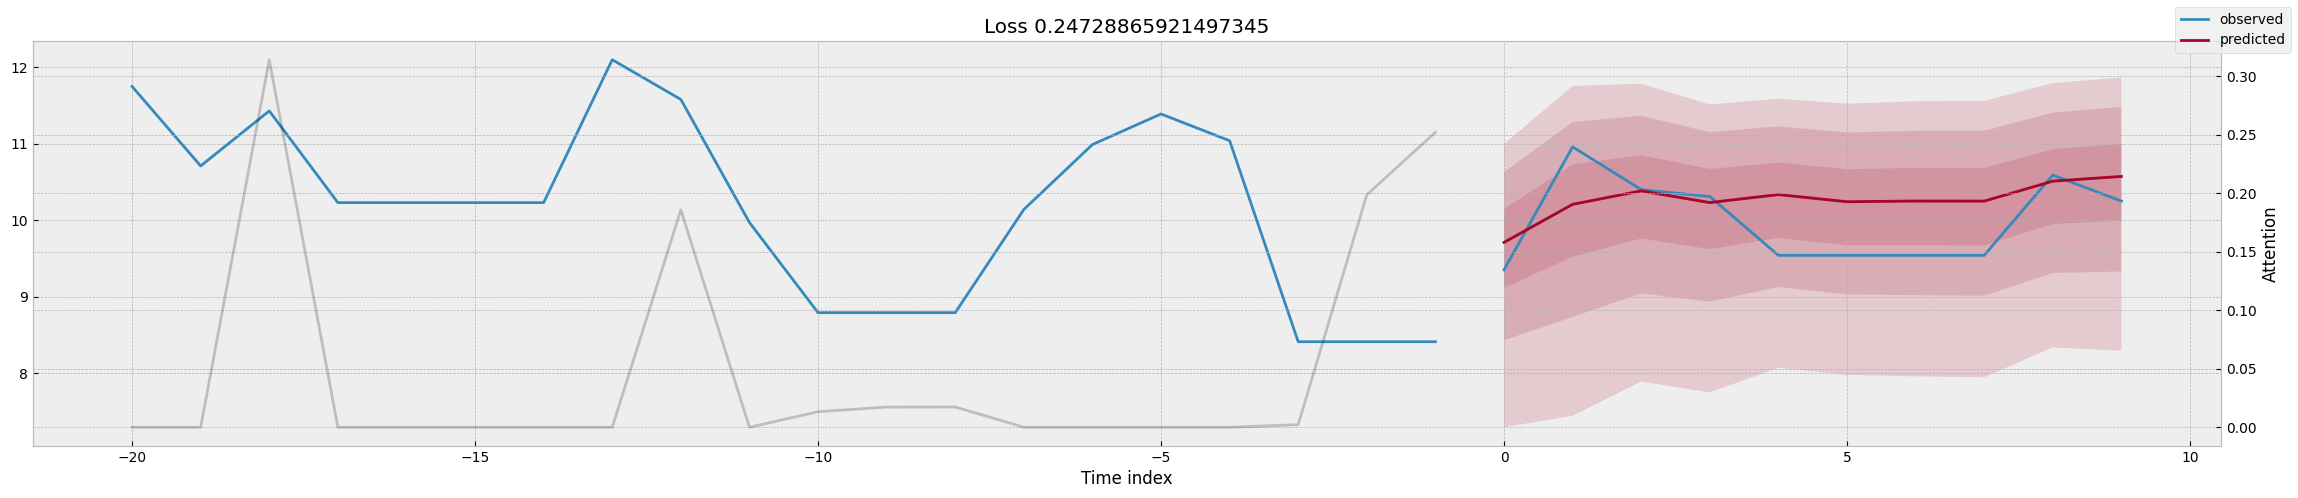

In [ ]:
import matplotlib.pyplot as plt

for idx in range(20):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KeyError: ignored

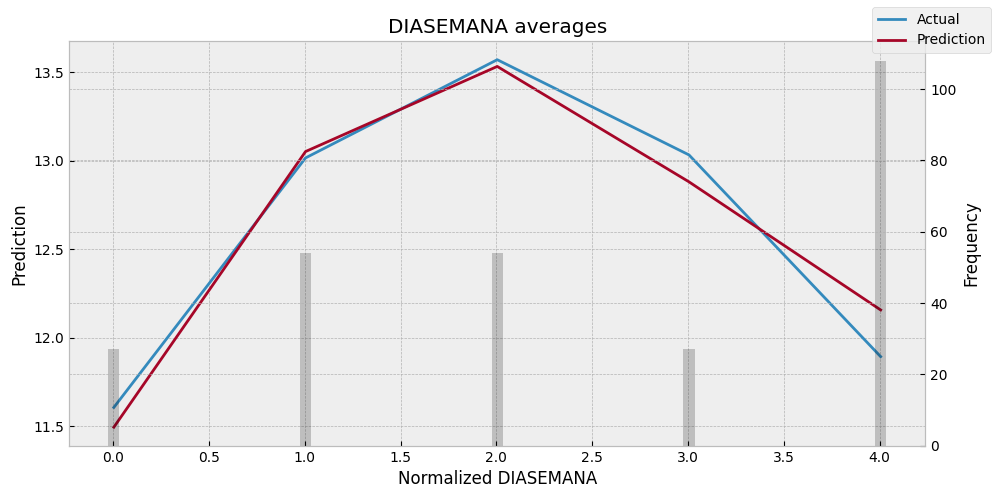

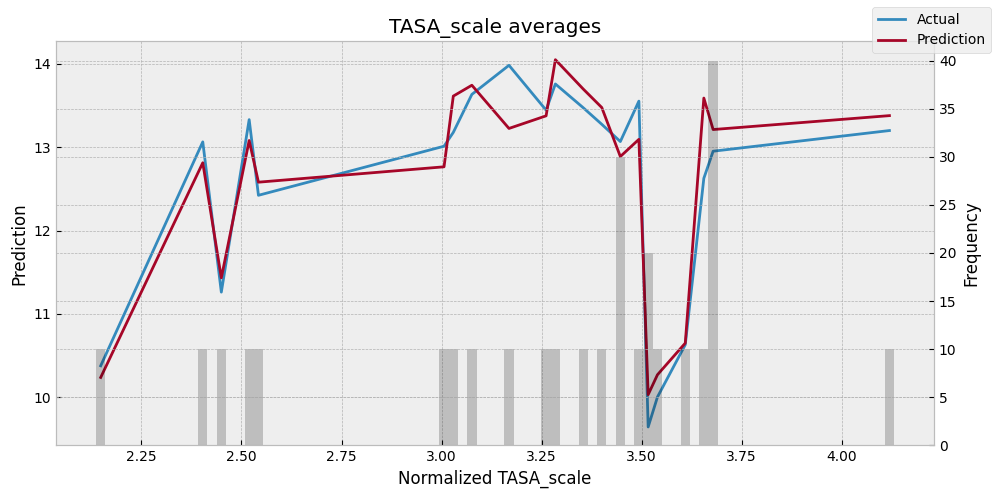

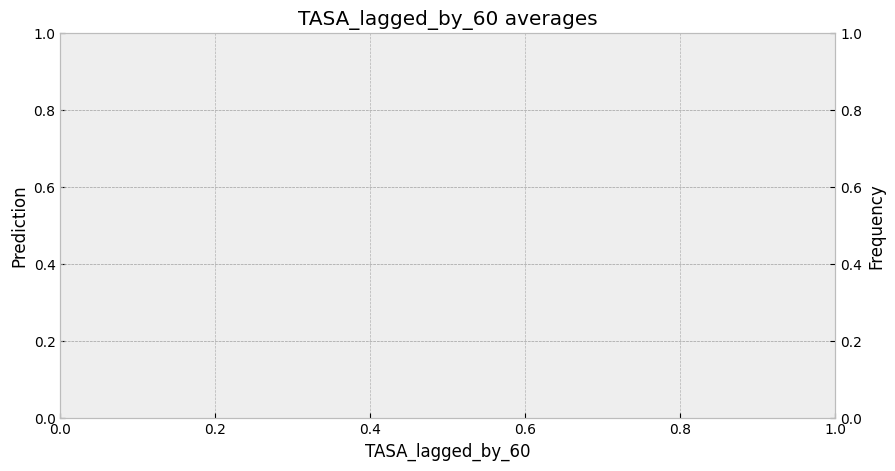

In [ ]:
val_prediction_results = best_tft.predict(
    val_dataloader, 
    mode='prediction', # get only median predictions
    return_x=True,
    )
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(val_prediction_results.x, val_prediction_results.output)
features = list(set(predictions_vs_actuals['support'].keys())-set(['TASA_lagged_by_10']))
for feature in features:
    best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name=feature);

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]




torch.Size([27, 10, 7])


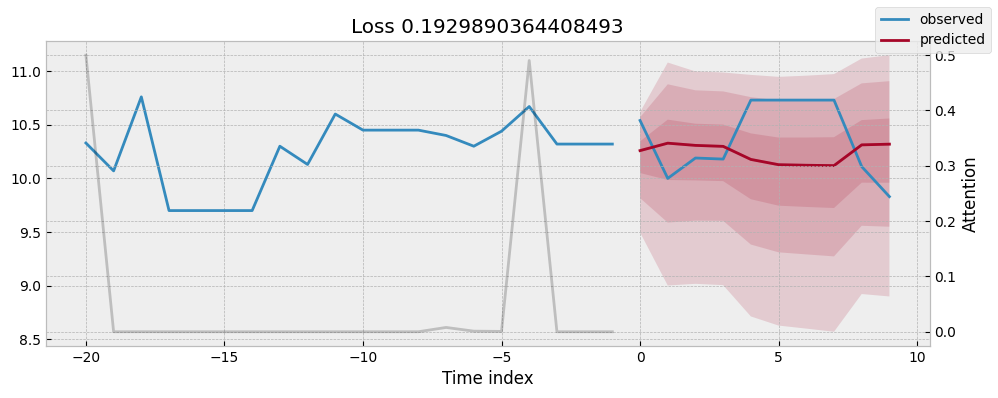

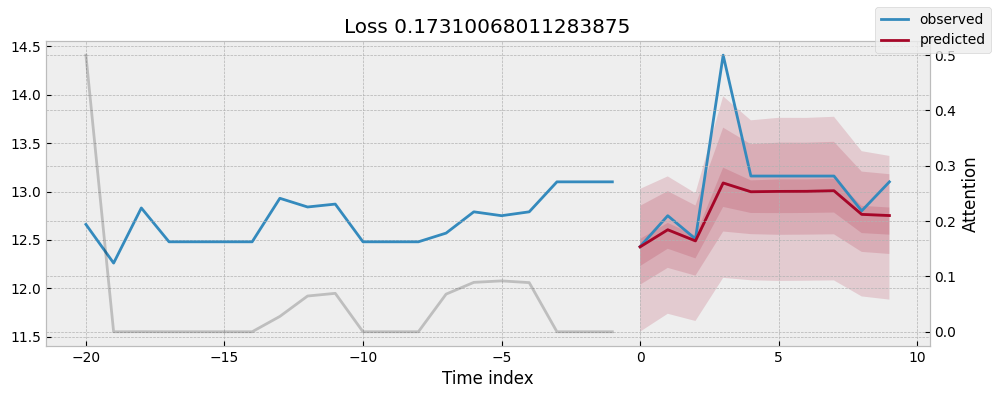

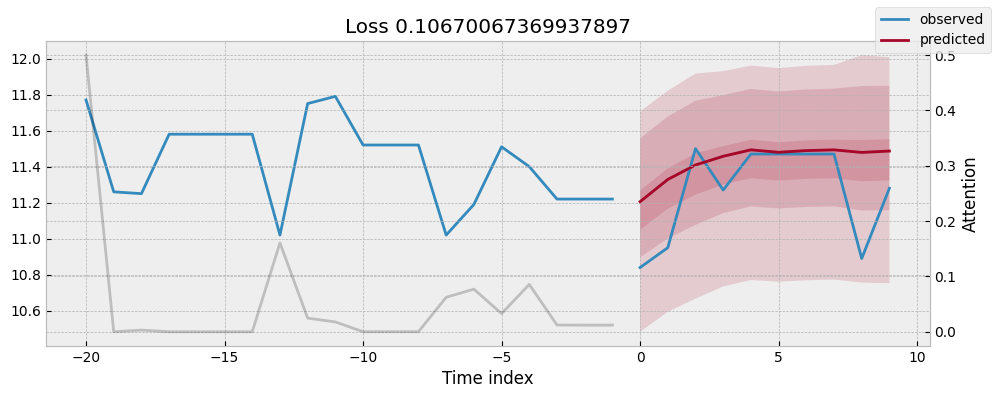

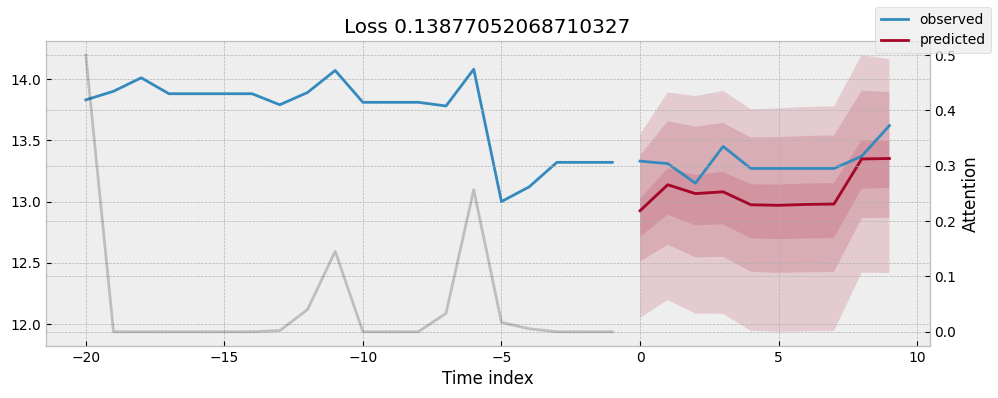

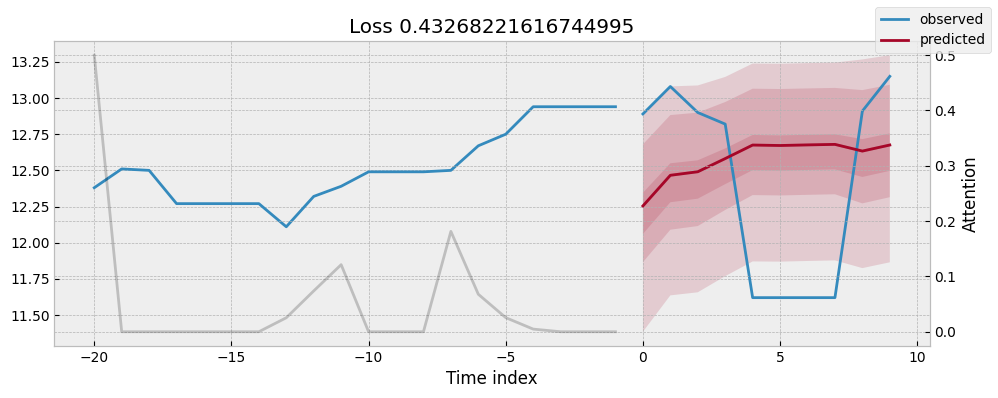

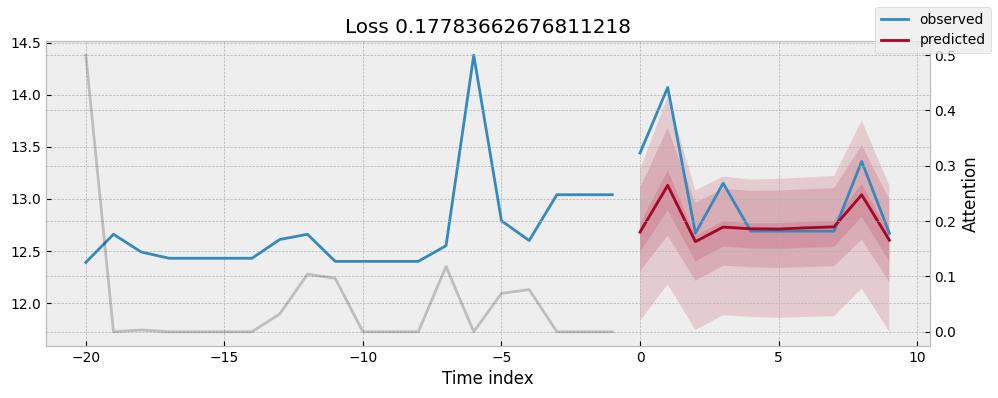

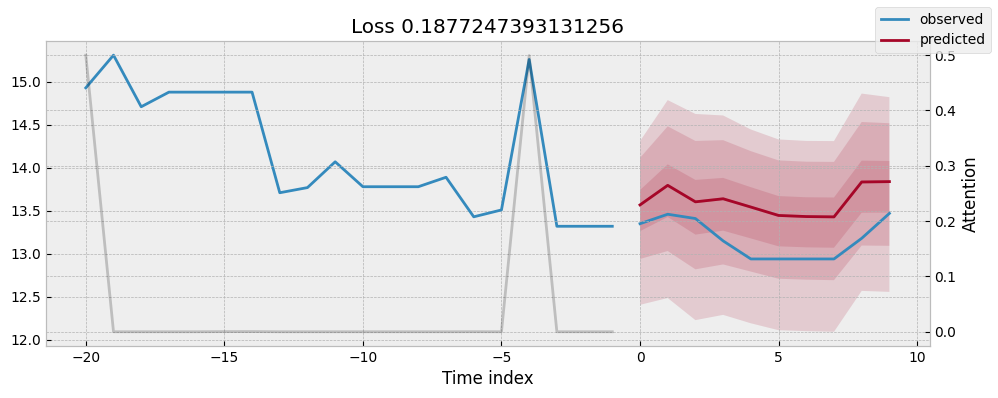

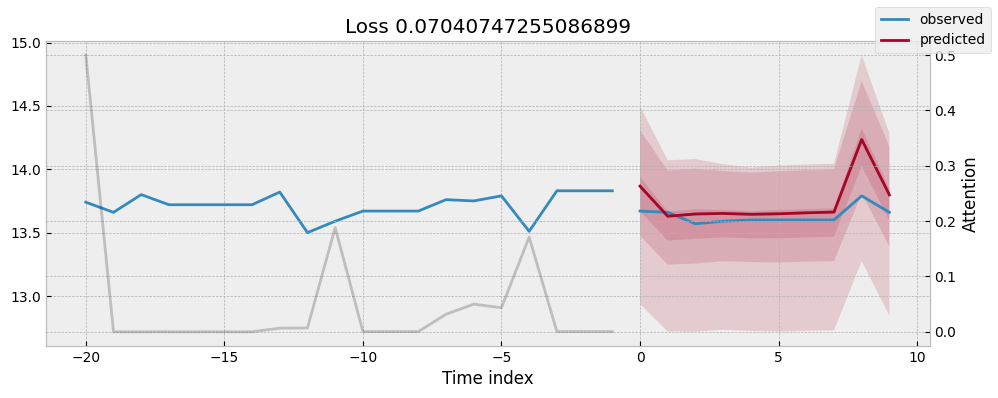

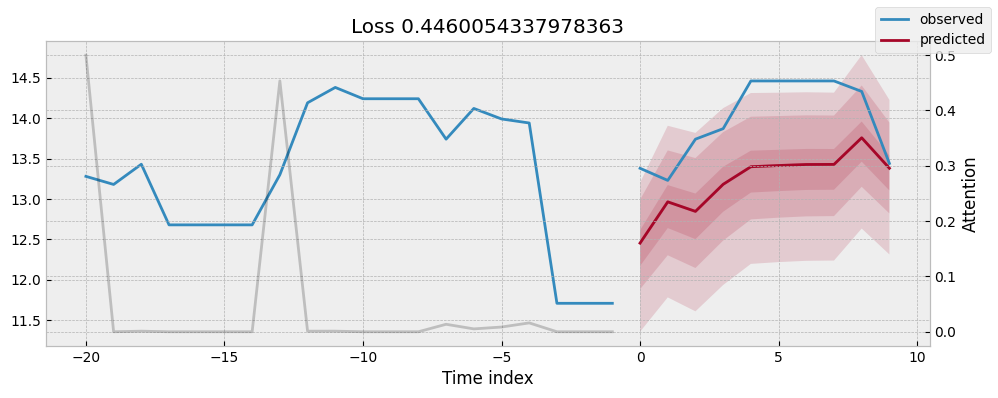

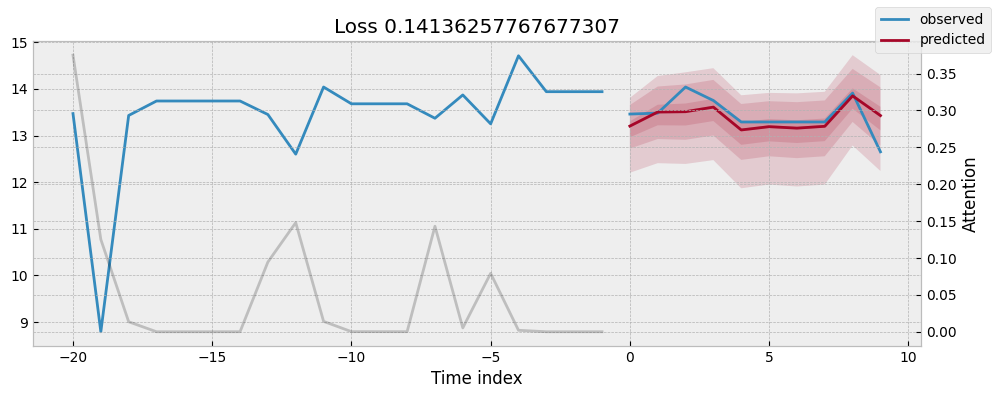

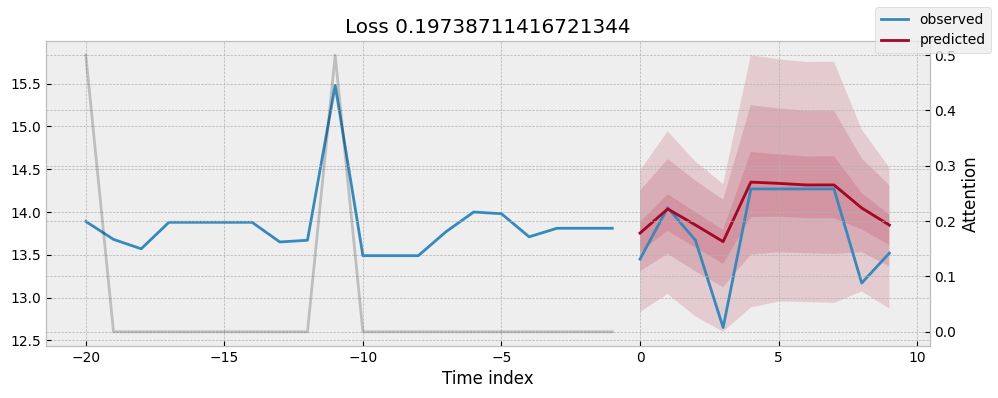

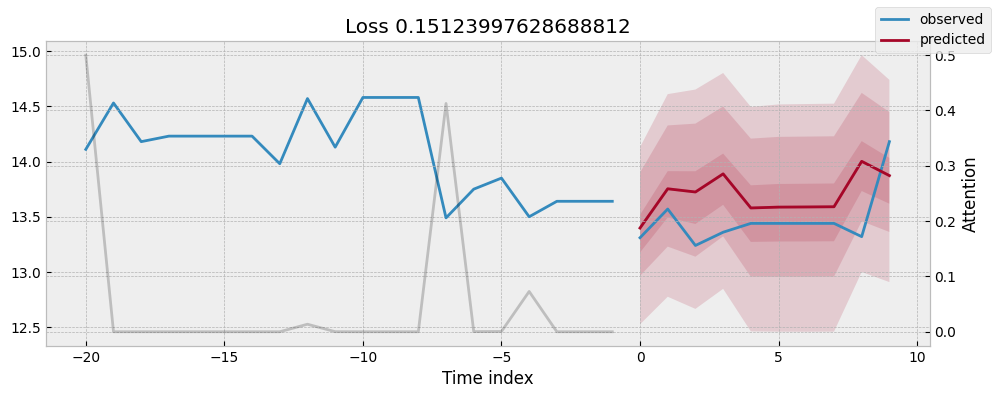

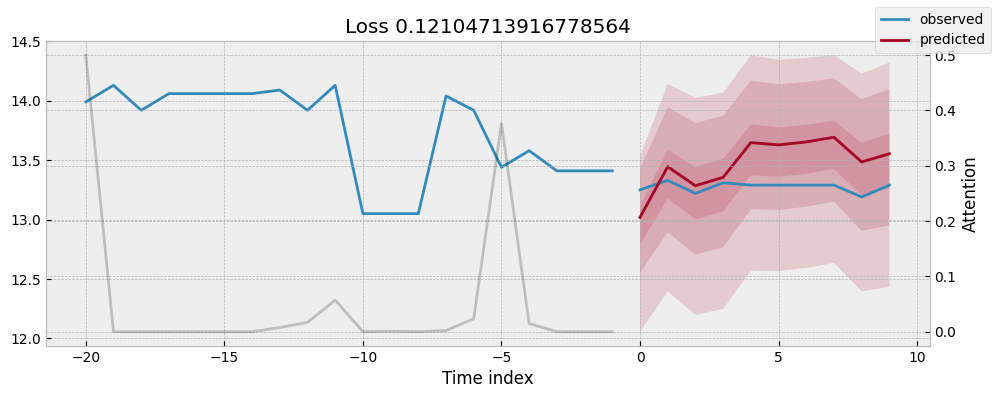

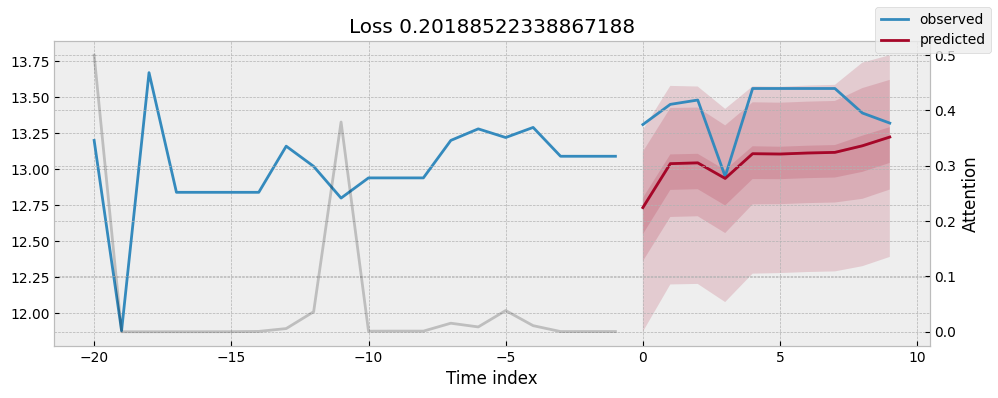

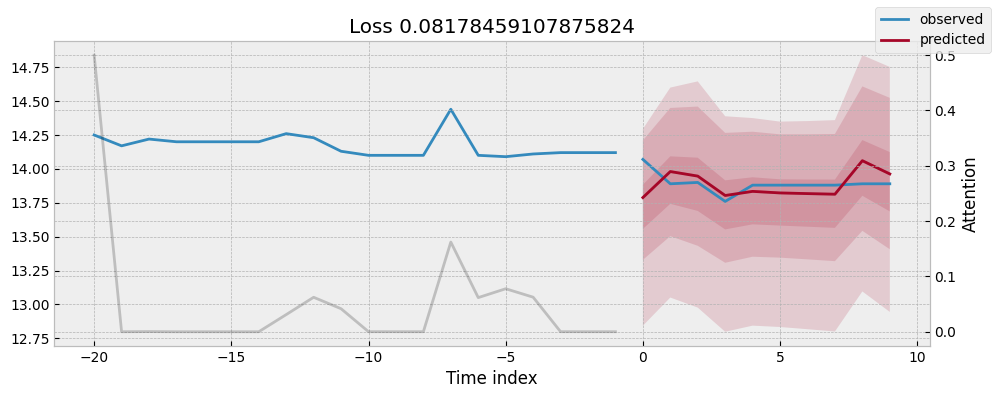

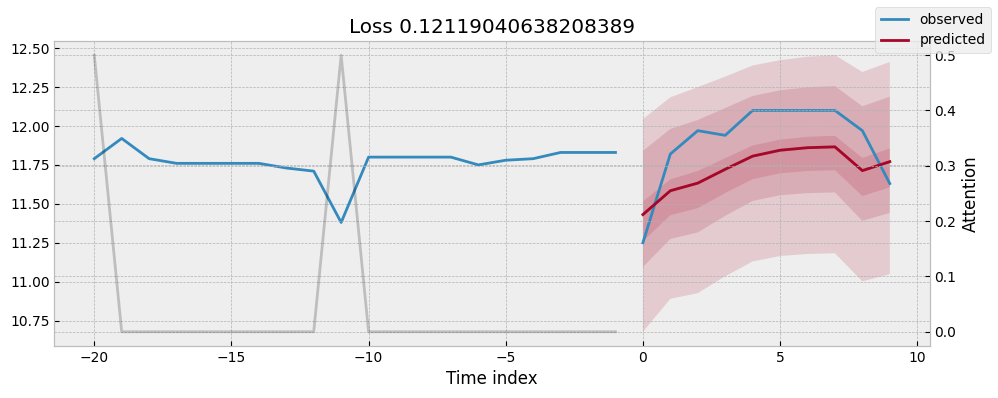

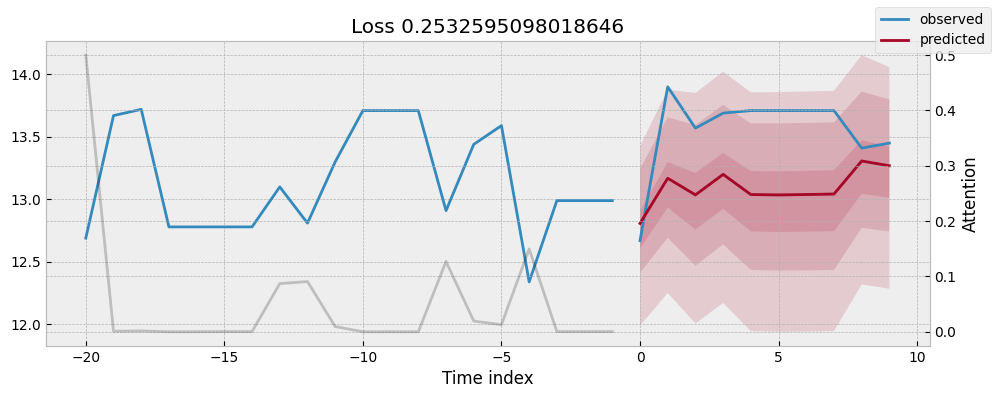

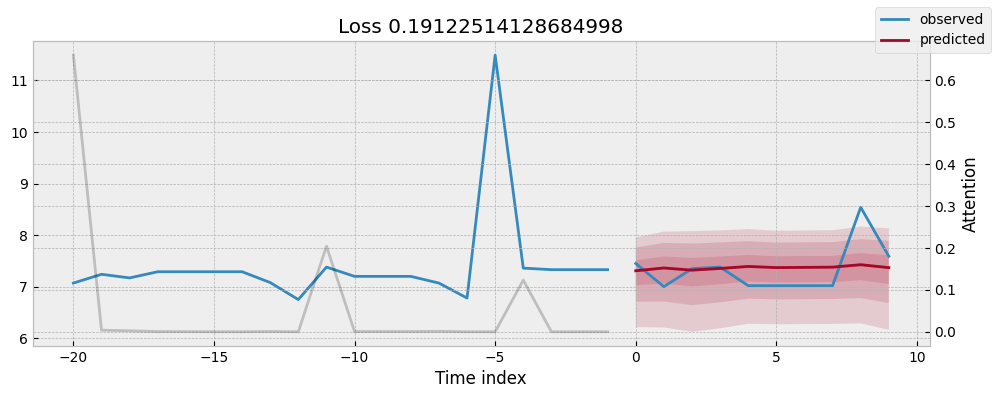

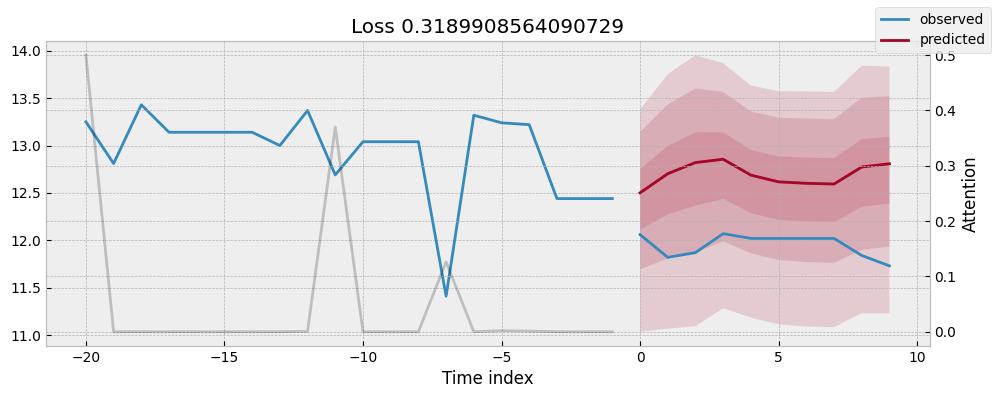

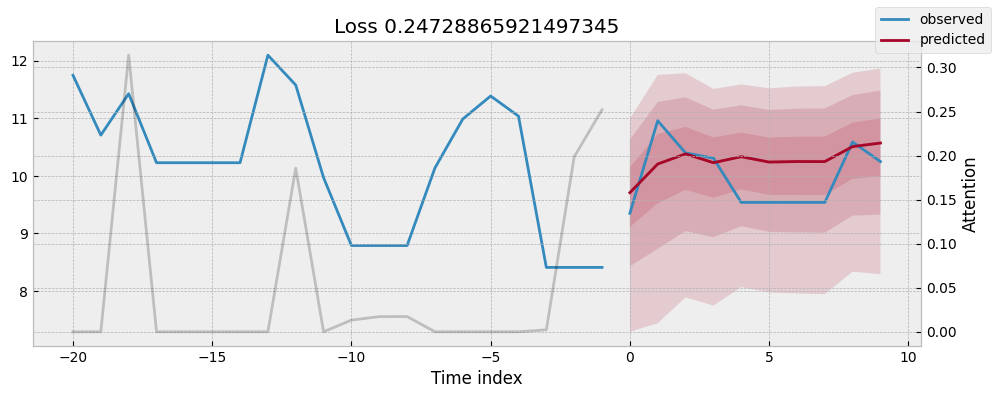

In [ ]:


x = best_tft.predict(val_dataloader, mode="raw", return_x=True).x
raw_pred = best_tft.predict(val_dataloader, mode="raw", return_x=True).output


print('\n')
print(raw_pred['prediction'].shape)

for idx in range(20):  
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(x, raw_pred, idx=idx, add_loss_to_title=True,ax=ax)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/base_model.py:105: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 10, 4, 20]). Returning list instead of torch.Tensor.
  warnings.warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/base_model.py:105: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 10, 4, 20]). Returning list instead of torch.Tensor.
  warnings.warn(


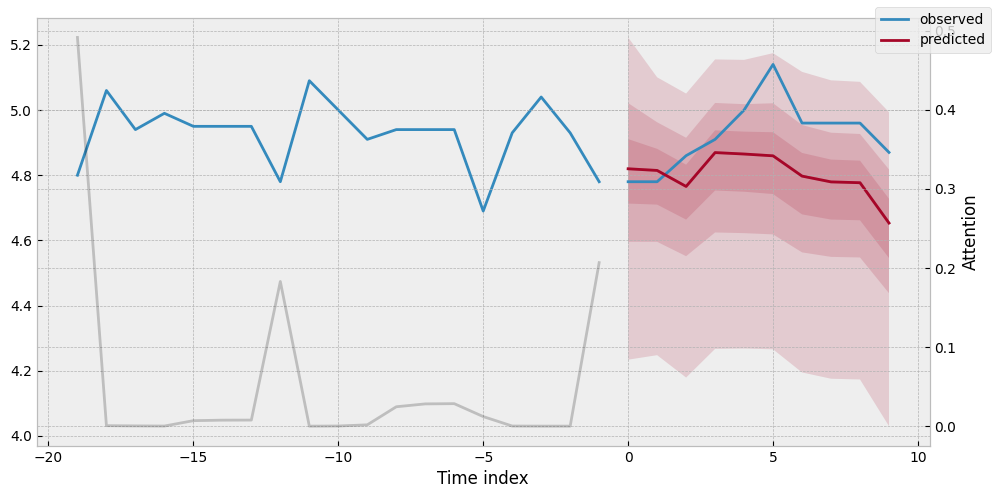

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
#print(training)

raw_pred = best_tft.predict(
    training.filter(lambda x: (x.NOMBREENTIDAD == "BANCOLOMBIA ")),
    mode="raw",
    return_x=True,
).output
x = best_tft.predict(
    training.filter(lambda x: (x.NOMBREENTIDAD == "BANCOLOMBIA ")),
    mode="raw",
    return_x=True,
).x

best_tft.plot_prediction(x, raw_pred, idx=0, ax=ax);


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x325 with 1 Axes>,
 'encoder_variables': <Figure size 700x350 with 1 Axes>,
 'decoder_variables': <Figure size 700x325 with 1 Axes>}

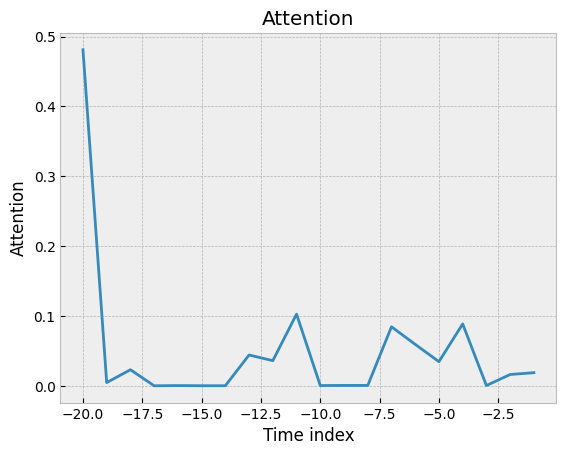

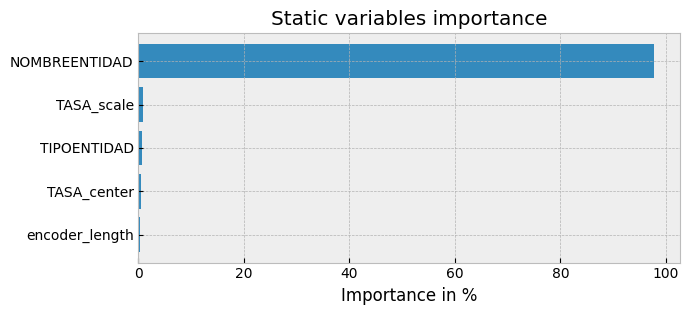

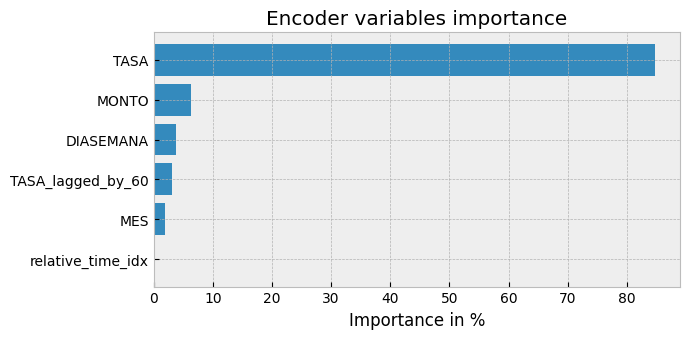

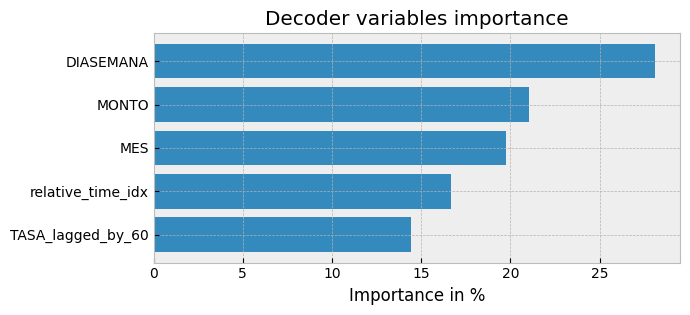

In [ ]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True).output
x = best_tft.predict(val_dataloader, mode="raw", return_x=True).x
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

      TIPOENTIDAD  CODIGOENTIDAD                   NOMBREENTIDAD FECHACORTE  \
1304            1              1                BANCO DE BOGOTA  2023-05-05   
1305            1              1                BANCO DE BOGOTA  2023-05-08   
1306            1              1                BANCO DE BOGOTA  2023-05-09   
1307            1              1                BANCO DE BOGOTA  2023-05-10   
1308            1              1                BANCO DE BOGOTA  2023-05-11   
...           ...            ...                             ...        ...   
47009          32              5  CONFIAR COOPERATIVA FINANCIERA 2023-05-17   
47010          32              5  CONFIAR COOPERATIVA FINANCIERA 2023-05-18   
47011          32              5  CONFIAR COOPERATIVA FINANCIERA 2023-05-19   
47012          32              5  CONFIAR COOPERATIVA FINANCIERA 2023-05-23   
47013          32              5  CONFIAR COOPERATIVA FINANCIERA 2023-05-24   

        TASA        MONTO MES  time_idx DIASEMANA  

AssertionError: ignored

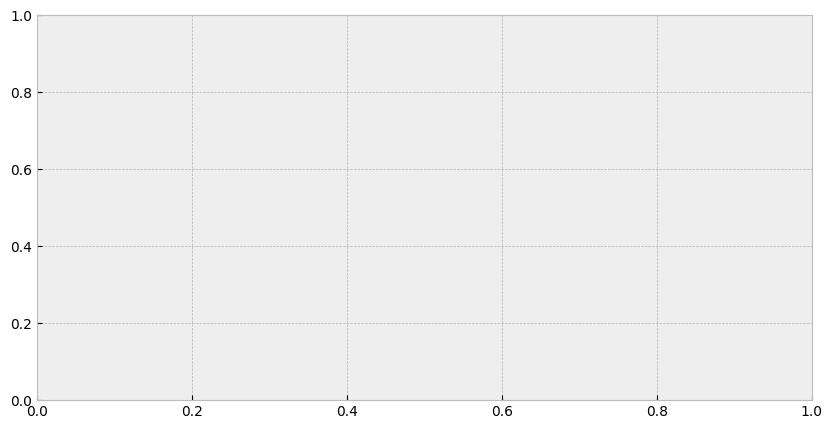

In [ ]:
#encoder data is the last lookback window: we get the last 1 week (168 datapoints) for all 5 consumers = 840 total datapoints

encoder_data = df[lambda x: x.time_idx > (x.time_idx.max() - max_encoder_length)]
last_data = df[lambda x: x.time_idx == x.time_idx.max()]

print(encoder_data)
print(last_data)

#decoder_data is the new dataframe for which we will create predictions. 
#decoder_data df should be max_prediction_length*consumers = 24*5=120 datapoints long : 24 datapoints for each cosnumer
#we create it by repeating the last hourly observation of every consumer 24 times since we do not really have new test data
#and later we fix the columns

decoder_data = pd.concat(
    [last_data.assign(time_idx=lambda x: x.time_idx + i) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

#fix the new columns
decoder_data["time_idx"] = (decoder_data["time_idx"] - decoder_data["time_idx"].min())

#decoder_data['time_idx'] = decoder_data['time_idx'].astype('int')
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data=new_prediction_data.query(" NOMBREENTIDAD == 'BANCOLOMBIA '")
new_prediction_data
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True).output
new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True).x
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);